SMA, EMA, MACD, Kalman, Fourier, Wavelet, STL on ARIMA, LSTM, CNN, RNN on different datasets

[Source](https://wire.insiderfinance.io/cracking-the-code-stock-prediction-with-attention-based-lstm-rnn-and-cnn-a-complete-python-2c46e8f25a12)

[Source2](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

[Source3](https://medium.com/@wl8380/mastering-day-trading-with-lstm-predicting-the-next-10-minutes-4e03f89fef3f)

[Optuna](https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html), [Link2](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc), [Link3](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc)

[Tensorflow example](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-output_models)

#### Import Libraries

In [1]:
# def import_libraries():
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import yfinance as yf
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention, Add, LayerNormalization, Layer
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import keras_tuner as kt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
# import xgboost as xgb
# import lightgbm as lgb
# import catboost as cb
from pykalman import KalmanFilter
import os
from scipy.fft import fft,ifft
from scipy.signal import morlet, cwt
import pywt

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error   


2025-01-08 11:01:59.362279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 11:01:59.392005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 11:01:59.392033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 11:01:59.392744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 11:01:59.397845: I tensorflow/core/platform/cpu_feature_guar

#### Fetch data

In [2]:
def fetch_stock_data(ticker):
    """
    Fetch Tesla's historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Tesla (TSLA) from Yahoo Finance
    ticker = ticker
    start_date = "2010-01-01"
    end_date = "2024-11-17"
    # tesla = yf.download(ticker, start=start_date, end=end_date)
    ticker = yf.Ticker(ticker)
    tesla_data = ticker.history(period="max",interval="1d")
    # tesla.head(4)
    # Return a DataFrame with the adjusted close prices
    # tesla_data = tesla[['Adj Close']].rename(columns={"Adj Close": "adjClose"})
    # tesla_data.index.name = "date"
    return tesla_data
# Fetch Tesla stock data
# tesla_data = fetch_tesla_stock_data()

# Display the first few rows of data
# print(tesla_data.head(10))

#### Filtering functions

##### Comparison plot of Actual(TEST), kalman, fourier, SMA, EMA, MACD, Wavelet

In [3]:
def plot_comparison(actual_test,pred_test, kalman=None, fourier=None, sma=None, ema=None, macd=None, wavelet=None):
# plot dataframe line chart
    global scaler, tesla_data
    plt.figure(figsize=(10, 6))
    # Inverse scale the actual stock prices
    y_raw = scaler.inverse_transform(actual_test.reshape(-1, 1))
    s = tesla_data.index[-len(y_raw):]
    plt.plot(s,y_raw,'black' ,label='Actual')
    plt.plot(s,pred_test,'orange' ,label='Predicted')
    if kalman is not None:
        #read csv file into dataframe
        kalman_df_pred = pd.read_csv(f'predicted_stock_price_kalman.csv',index=False)
        plt.plot(s,kalman_df_pred['kalman_pred'], 'red',label='Kalman')
    if fourier is not None:
        fourier_df_Pred = pd.read_csv(f'predicted_stock_price_fourier.csv',index=False)
        plt.plot(s,fourier_df_Pred['fourier_pred'],'green',label='Fourier')
    if sma is not None:
        sma_df_pred = pd.read_csv(f'predicted_stock_price_SMA.csv',index=False)
        plt.plot(s,sma_df_pred['sma_pred'],'yellow', label='SMA')
    if ema is not None:
        ema_df_pred = pd.read_csv(f'predicted_stock_price_EMA.csv',index=False)
        plt.plot(s,ema_df_pred['ema_pred'],'lightblue' ,label='EMA')
    if macd is not None:
        macd_df_pred = pd.read_csv(f'predicted_stock_price_MACD.csv',index=False)
        plt.plot(s,macd_df_pred['macd_pred'],'magenta' ,label='MACD')
    if wavelet is not None:
        wavelet_df_pred = pd.read_csv(f'predicted_stock_price_wavelet.csv',index=False)
        plt.plot(s,wavelet_df_pred['wavelet_pred'], 'cyan',label='Wavelet')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time')           
    plt.ylabel('Value')
    plt.legend()
    plt.show()


##### Kalman

In [4]:
def kalman_filtering(org_data):
    kf = KalmanFilter(transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.0001)

    mean, cov = kf.filter(org_data.values)
    mean = pd.Series(mean.flatten(), index=org_data.index)

    # Apply the smoother to the observations
    smoothed_state_means, smoothed_state_covariances = kf.smooth(org_data.values)
    s_mean = pd.Series(smoothed_state_means.flatten(), index=org_data.index)

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,org_data.values - mean, 'red', lw=1.5,label='kalman filtered')
    plt.plot(org_data.index,org_data.values - s_mean, 'yellow', lw=1.5,label='Kalman smoothed')
    plt.title(f"{filter} -Kalman filtered price fluctuation")
    plt.ylabel("Deviation from the mean ($)")
    plt.xlabel("Years")
    plt.legend()
    #convert to dataframe
    kalman_df = pd.DataFrame({'filtered': org_data.values - mean, 'kal_smoothed':org_data.values - s_mean})
    return kalman_df

##### Fourier

In [5]:
def fourier_transform(org_data):
    global frequencies,fourier_reconstructed_signal,fft_values,stock_data
    # calcualte the fourier transform
    global threshold
    fft_values = np.fft.fft(org_data)

    # plot the original signal
    plt.figure(figsize=(20,11))
    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, org_data)
    plt.title(f'{filter} -Original Signal (Time Domain)')
    plt.xlabel('Time [s]')
    plt.ylabel('Price')

    # plot the fourier transform of the simulated sequence
    frequencies = np.fft.fftfreq(len(stock_data.index), d=1)
    print("freq-",frequencies)
    print("amp-",np.abs(fft_values))
    plt.subplot(3, 1, 2)
    plt.plot(frequencies, np.abs(fft_values))
    plt.title(f'{filter} -Fourier Transform (Frequency Domain)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    

    # Step 2: Filter High Frequencies (Denoising) 
    
    # Filter threshold: keep only low frequencies 
    fft_filtered = np.copy(fft_values) 
    fft_filtered[np.abs(frequencies) > threshold] = 0 # Zero out high frequencies 
    # Reconstruct the Signal (Inverse Fourier Transform) 
    fourier_reconstructed_signal = np.fft.ifft(fft_filtered).real
    
    # Plot Reconstructed Signal 
    plt.subplot(3, 1, 3)   
    plt.plot(stock_data.index, fourier_reconstructed_signal, label="Reconstructed Signal (Low Pass Filter)") 
    plt.xlabel("Time") 
    plt.ylabel("Price") 
    plt.title(f"{filter} -Denoised Time Series") 
    plt.legend() 
    plt.tight_layout()
    plt.show()

    fourier_df = pd.DataFrame({'filtered': fourier_reconstructed_signal}) 
    return fourier_df

In [6]:
#find the lowest positive value in an array frequencies
# def find_lowest_positive_value(frequencies):
#     return min([freq for freq in frequencies if freq > 0])
# find_lowest_positive_value(frequencies)

# Step 3: Identify Dominant Frequencies 
# dominant_freqs = frequencies[np.argsort(np.abs(fft_values))[-5:]]
# dominant_freqs
# dominant_amplitudes = np.abs(fft_values)[np.argsort(np.abs(fft_values))[-5:]] 
# dominant_amplitudes

In [7]:
# Step 4: Add Sinusoidal Features for Forecasting 
# sin_features = [np.sin(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# cos_features = [np.cos(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# seasonality_features = np.column_stack(sin_features + cos_features) 

# Combine Features with Original Signal 
# time_series_df = pd.DataFrame({ "Time": t, "Original_Signal": signal, "Denoised_Signal": reconstructed_signal }) 
# for i, freq in enumerate(dominant_freqs[dominant_freqs > 0]): 
#     time_series_df[f"Sin_{i}"] = np.sin(2 * np.pi * freq * t) 
#     time_series_df[f"Cos_{i}"] = np.cos(2 * np.pi * freq * t)

##### SMA

In [8]:
def SMA_transform(org_data):
    #transform close price to simple moving average
    global sma_win
    # sma_win = 20
    temp = org_data.rolling(window=sma_win,min_periods=1).mean()
    # print(temp)
    sma_df = pd.DataFrame(temp)
    #rename the column in sma_df   
    sma_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,sma_df.filtered, 'red', lw=1.5,label='SMA filtered')
    plt.title(f"{filter} -SMA filtered price fluctuation")
    plt.ylabel("SMA values")
    plt.xlabel("Years")
    plt.legend()

    return sma_df

##### EMA

In [9]:
def EMA_transform(org_data):
    #transform close price to simple moving average
    global ema_win
    temp = org_data.ewm(span=ema_win).mean()
    # print(temp)
    ema_df = pd.DataFrame(temp)
    #rename the column in sma_df
    ema_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,ema_df.filtered, 'red', lw=1.5,label='EMA filtered')
    plt.title(f"{filter} -EMA filtered price fluctuation")
    plt.ylabel("EMA values")
    plt.xlabel("Years")
    plt.legend()

    return ema_df

##### MACD

In [10]:
def MACD_transform(org_data):
    # Create MACD
    d_26ema = org_data.ewm(span=26).mean()
    d_12ema = org_data.ewm(span=12).mean()
    d_MACD = d_12ema-d_26ema
    macd_df = pd.DataFrame({'filtered': d_MACD})
    #rename the column in sma_df
    # macd_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,macd_df.filtered, 'red', lw=1.5,label='MACD filtered')
    plt.title(f"{filter} -MACD filtered price fluctuation")
    plt.ylabel("MACD values")
    plt.xlabel("Years")
    plt.legend()

    return macd_df
#calculate MACD

##### Wavelet

In [11]:
def wavelet_deconstruction_plot(data, wavelet_name):
    global details, approximation, wavelet
    # Step 1: Generate Synthetic Time Series Data 
    # np.random.seed(42) 
    # t = np.linspace(0, 10, 1024) 
    # Time vector (must be a power of 2 for DWT) 
    # signal = 5 * np.sin(2 * np.pi * 1 * t) + 2 * np.sin(2 * np.pi * 0.25 * t) + np.random.normal(0, 0.5, len(t)) 
    # Plot Original Signal 
    # plt.figure(figsize=(10, 4)) 
    # print('HEREEEEEEEEE')
    # plt.plot(data.index, data['Close'].values, label="Original Signal") 
    # plt.xlabel("Time") 
    # plt.ylabel("Close price") 
    # plt.title("Time Series Data") 
    # plt.legend() 
    # plt.show() 
    # Step 2: Perform Discrete Wavelet Transform (DWT) 
    wavelet = wavelet_name # 'db4' 
#Different wavelet families can be tested
    # Daubechies wavelet
    max_level = pywt.dwt_max_level(len(data['Close'].values), pywt.Wavelet(wavelet).dec_len) 
    # Max decomposition level 
    coeffs = pywt.wavedec(data['Close'].values, wavelet, level=max_level)

    # Perform wavelet decomposition 
    approximation = coeffs[0] 
    # Approximation coefficients (low-frequency) 
    details = coeffs[1:] 
    # Detail coefficients (high-frequency) 
    print("length of details-",len(details))
    # Step 3: Visualize Wavelet Decomposition 
    
    # plt.figure(figsize=(20, 15)) 
    # plt.subplot(len(details)+1, 1, 1) 
    # plt.plot(approximation, label="Approximation (Low Frequencies)") 
    # plt.title("Approximation Coefficients (A)") 
    # plt.legend() 
    # for i, detail in enumerate(details, 1): 
    #     plt.subplot(len(details)+1, 1, i + 1) 
    #     plt.plot(detail, label=f"Detail Coefficients (D{i})") 
    #     plt.title(f"Detail Coefficients (D{i})") 
    #     plt.legend() 
    # plt.tight_layout() 
    # plt.show() 

In [12]:
def wavelet_denoising(data,detail_index,approx_enable=True,threshold_enable=False,thresh_value=0):
    global details, approximation, wavelet,wavelet_df
    # Step 4: Reconstruct Signal (Inverse Wavelet Transform) 
    # Reconstruct only the approximation (low-frequency content) 
    # if not detail_index in range(len(details)):
    #     detail_index = 0
    #     print("Detail_index",detail_index)
    
    print("Threshold enabled-",threshold_enable)
    if not threshold_enable:
        if approx_enable:
            reconstructed_signal_low = pywt.waverec([approximation] + [np.zeros_like(d) for d in details], wavelet) 
            # Reconstruct signal with selective details (e.g., smooth trends + some details) 
        else:
        # Different details coefficients can be tested
            selective_coeffs = [approximation] + [details[i] if i == detail_index else np.zeros_like(d) for i, d in enumerate(details)] 
            reconstructed_signal_selective = pywt.waverec(selective_coeffs, wavelet) 

        # Plot Original vs Reconstructed Signal 

        plt.figure(figsize=(12, 6)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        if approx_enable:
            plt.plot(data.index[:len(reconstructed_signal_low)], reconstructed_signal_low, label="Low Frequencies (Approximation)", color='red') 
        else:
            plt.plot(data.index[:len(reconstructed_signal_selective)], reconstructed_signal_selective, label="Selective Reconstruction", color='green') 
        plt.xlabel("Time") 
        plt.ylabel("Close Price") 
        plt.title("Signal Reconstruction from Wavelet Coefficients") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        threshold = thresh_value
        # Adjust based on noise level 
        thresholded_details = [pywt.threshold(d, threshold, mode='soft') for d in details] 

        # Reconstruct the denoised signal 
        denoised_coeffs = [approximation] + thresholded_details 
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet) 

        # Plot Denoised Signal 
        plt.figure(figsize=(10, 4)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        plt.plot(data.index[:len(denoised_signal)], denoised_signal, label="Denoised Signal", color='orange') 
        plt.xlabel("Time") 
        plt.ylabel("Amplitude") 
        plt.title("Denoised Signal Using Wavelet Transform") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        wavelet_df = pd.DataFrame({'filtered': denoised_signal})
        #rename the column in sma_df
        # print(wavelet_df)
        return wavelet_df
    else:
        if approx_enable:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_low})
            # print(wavelet_df)
            return wavelet_df
        else:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_selective})
            # print(wavelet_df)
            return wavelet_df

In [13]:
def wavelet_transform(org_data,detail_index, wavelet_name,approx_enable=True,threshold_enable=False,thresh_value=0):
    wavelet_deconstruction_plot(org_data, wavelet_name)
    ret_df = wavelet_denoising(org_data,detail_index,approx_enable,threshold_enable,thresh_value)
    return ret_df

##### STL

In [14]:
def plot_components_STL(result,org):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [15]:
#Assuming period of 1 day
def stl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    stl = STL(tesla_data['Close'], period=period)
    result_stl = stl.fit()

    # Plot the results
    plot_components_STL(result_stl,tesla_data)
    stl_df = pd.DataFrame({'filtered':result_stl.observed - result_stl.resid})
    return stl_df

##### MSTL

In [16]:
def plot_components(result,org):
  
  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=1200,
      width=1200
  )

  fig.show()

In [17]:
#code to calculate variance 
#High variance indicate the presence of noise
# def calculate_variance(data):
#     mean = sum(data) / len(data)
#     variance = sum((x - mean) ** 2 for x in data) / len(data)
#     return variance
                                                        

In [18]:
# from statsmodels.tsa.stattools import adfuller
# def Augmented_Dickey_Fuller_Test_func(series):
#     # print (f'Dickey-Fuller test results for columns: {column_name}')
#     dftest = adfuller(series, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
#     if dftest[1] <= 0.05:
#         print("Conclusion:====>")
#         print("Reject the null hypothesis")
#         print("The data is stationary")
#     else:
#         print("Conclusion:====>")
#         print("The null hypothesis cannot be rejected")
#         print("The data is not stationary")

In [19]:
# result_mstl.observed
# Augmented_Dickey_Fuller_Test_func(result_mstl.resid)
# calculate_variance(result_mstl.resid)

In [20]:
#Assuming period of 1 day
def mstl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    mstl = MSTL(tesla_data['Close'], periods=period)
    result_mstl = mstl.fit()

    # Plot the results
    plot_components(result_mstl,tesla_data)
    mstl_df = pd.DataFrame({'filtered':result_mstl.observed - result_mstl.resid})
    return mstl_df

#### Create sequences

In [21]:
# def create_sequences(data, window_size, prediction_steps):
#     X = []
#     y = []
#     for i in range(window_size, len(data) - prediction_steps):
#         X.append(data[i-window_size:i, 0]) # input sequence
#         y.append(data[i, 0]) # target value (price at the next timestep)
#     return np.array(X), np.array(y)

def create_sequences(data, window_size, prediction_steps=10):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0]) # input sequence
        y.append(data[i + window_size, 0]) # target value (price at the next timestep)
    return np.array(X), np.array(y)

#### Model Definition

In [22]:
# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], input_shape[2]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W)
        a = tf.matmul(q, inputs, transpose_b=True)
        attention_weights = tf.nn.softmax(a, axis=-1)
        return tf.matmul(attention_weights, inputs)

# rnn model with attention and early stopping
def build_rnn_model_with_attention(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    model.add(SimpleRNN(units=u, return_sequences=True, input_shape=input_shape,activation=actv_name))
    model.add(Dropout(d))
    
    # Attention layer
    model.add(AttentionLayer())
    model.add(LayerNormalization())
    for i in range(no_of_layers):
        model.add(SimpleRNN(units=u, return_sequences=True,activation=actv_name))
        model.add(Dropout(d))
    model.add(SimpleRNN(units=u, return_sequences=False,activation=actv_name))
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

# RNN model without attention and early stopping
def build_rnn_model(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    print(input_shape)
    model.add(SimpleRNN(units=u, return_sequences=True, input_shape=input_shape))#,activation=actv_name))
    model.add(Dropout(d))
    for i in range(no_of_layers):
        model.add(SimpleRNN(units=u, return_sequences=True))#,activation=actv_name))
        model.add(Dropout(d))
    # model.add(SimpleRNN(units=u, return_sequences=True))
    # model.add(Dropout(d))
    model.add(SimpleRNN(units=u, return_sequences=False))#,activation=actv_name))
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

#### Build Model

In [23]:
def build_model(window_size,d,u,split_size,optimizer_option,num_of_layers,loss_options,actv_option):
    global scaler_X,scaler_Y,raw_data,scaled_data,attn,X_train, X_test, y_train, y_test,scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    X, y = create_sequences(raw_data, window_size)
    # Reshape input data to be in the shape [samples, time steps, features]
    # X = X.reshape(X.shape[0], X.shape[1], 1)
    # Split the data into training and testing sets
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=split_size, shuffle=False)
    # print(f"Training data shape: {X_train.shape}")
    # print(f"Testing data shape: {X_test.shape}")
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=False)
    print("unscaled X_train size",X_train.shape)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))
   
    scaled_train_X = scaler_X.fit_transform(X_train)
    scaled_val_X = scaler_X.transform(X_val)
    scaled_test_X = scaler_X.transform(X_test)

    scaled_train_Y = scaler_Y.fit_transform(y_train.reshape(-1,1)).flatten()
    scaled_val_Y = scaler_Y.transform(y_val.reshape(-1,1)).flatten()
    scaled_test_Y = scaler_Y.transform(y_test.reshape(-1,1)).flatten()

    scaled_train_X = scaled_train_X.reshape(scaled_train_X.shape[0], scaled_train_X.shape[1], 1)
    scaled_val_X = scaled_val_X.reshape(scaled_val_X.shape[0], scaled_val_X.shape[1], 1)
    scaled_test_X = scaled_test_X.reshape(scaled_test_X.shape[0], scaled_test_X.shape[1], 1)

    print("scaled X_train size",scaled_train_X.shape,scaled_train_Y.shape)
    if attn:
        model = build_rnn_model_with_attention(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
        # Implement EarlyStopping to prevent overfitting            
    else:
        # Build the RNN model
        model = build_rnn_model(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
    return model

#### Hyperparameter Optimization

In [24]:
def objective_rnn(trial):
    global  X_train,y_train,X_test,y_test,history, model, scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    win_size = trial.suggest_int('win_size', 10, 100,step=10, log=False)
    epoch_no = trial.suggest_int('epoch_no', 10, 100,step=10, log=False)
    split_size = trial.suggest_float('split_size', 0.2, 0.5,step=0.1,log=False)
    # attn = trial.suggest_categorical('attn', [True, False])
    units = trial.suggest_int('units', 30, 70,step=10,log=False)
    drop_out = trial.suggest_float('drop_out', 0.2, 0.5,step=0.1,log=False)
    optimizer_options = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    num_of_layers = trial.suggest_int('no_layers', 2, 9,step=2, log=False)
    loss_options = trial.suggest_categorical('loss_fn_name', ['mean_squared_error', 'mean_squared_logarithmic_error', 'huber_loss','log_cosh'])    
    activation_option = trial.suggest_categorical('activation_name', ['relu', 'gelu','selu'])
    
    model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_options,activation_option)
    # build_rnn_model(input_shape,u,d)
    # model.compile(optimizer='adam', loss='mean_squared_error')
    

    # Implement EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with EarlyStopping and 50 epochs
    
    history = model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y),verbose=1, shuffle=False, callbacks=[early_stopping])
    loss = history.history['val_loss']
    print("loss value",loss)
    return min(loss)

#### Evaluate model

In [25]:
# Evaluate the model
def evaluate_model(model, x_data,y_data,filter):
    global predicted_stock_price,scaler_X,scaler_Y,mape, mae, rmse, r2,y_raw,predicted_stock_price_raw
    predicted_stock_price = model.predict(x_data)
    predicted_stock_price_raw = scaler_Y.inverse_transform(predicted_stock_price)

    # Inverse scale the actual stock prices
    y_raw = scaler_Y.inverse_transform(y_data.reshape(-1, 1))
    #save predicted value in a dataframe
    predicted_stock_price_raw = predicted_stock_price_raw.flatten()
    pred_df = pd.DataFrame({f"{filter}_pred":predicted_stock_price_raw})
    pred_df.to_csv(f'RNN_predicted_stock_price_{filter}.csv', index=False)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_raw, predicted_stock_price_raw)
    #calculate MAE, RMSE, R2
    mae = mean_absolute_error(y_raw, predicted_stock_price_raw)
    rmse = root_mean_squared_error(y_raw, predicted_stock_price_raw)
    r2 = r2_score(y_raw, predicted_stock_price_raw)
    #save 
    print(f"**********************{filter} filter***************************")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print mae, rmse and r2
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    # return mape, mae, rmse, r2
    # return rmse
    



#### Plot simple & interative graph

In [26]:
def plot_simple(df,split,title,ticker,y_actual, predicted_stock_price_raw,width=10,height=6):
    # Plot the results
    global window_size,y_train
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    #plot date in x axis
    plt.figure(figsize=(width,height))
 
    plt.figure(figsize=(width, height))    
    plt.plot(s,y_actual, label=f"Actual {ticker} Stock Price", color='blue')
    plt.plot(s,predicted_stock_price_raw, label=f"Predicted {ticker} Stock Price", color='red')
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Raw Stock Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_interative(df,split,title,tick,y_actual,y_pred):
    global y_train,window_size
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    fig = go.Figure(data=[
           go.Scatter(x=s, y=y_actual.flatten(), mode='lines', name='Actual'),
           go.Scatter(x=s, y=y_pred.flatten(), mode='lines', name='Predicted')])
    fig.update_layout(title=title+f'-{tick}', xaxis_title='Time', yaxis_title='Close price')
    fig.show()

#### Original data Scaled

In [27]:
def org_data_split(org_data,split_size,window_size):
    global Org_X_train,Org_y_train,Org_X_val,Org_y_val,Org_X_test,Org_y_test
    Org_X, Org_y = create_sequences(org_data, window_size)
    Org_X_train, Org_X_rest, Org_y_train, Org_y_rest = train_test_split(Org_X, Org_y, test_size=split_size, shuffle=False)
    Org_X_val, Org_X_test, Org_y_val, Org_y_test = train_test_split(Org_X_rest, Org_y_rest, test_size=0.5, shuffle=False)
    

#### Compile all functions

In [28]:
# def abc(tick,ws,ps,u,d,n_t,filter,epoch_no=70,batch_size_no=32,split_size=0.2,attn=False):
def abc(file_name,tick,n_t,filter,study_name,tuning,detail_index=0,wavelet_name="db4",approx_enable=True,threshold_enable=False,thresh_value=0,mstl_period=[7],stl_period=7):
    global model,study_rnn, window_size,stock_data, raw_data,scaler, scaled_data, X, y,X_train, X_test, y_train, y_test,history,model
    # import_libraries()

    
    # stock_data = fetch_stock_data(tick)
    if filter == 'hybrid':
        hybrid_df = pd.read_csv('AKAM_autoencoder_data.csv',index_col=0)
        stock_data = hybrid_df
    else:
        # stock_data = fetch_stock_data(tick)
        if os.path.isfile(file_name):
            print(f"The file '{file_name}' does exist.")
            stock_data = pd.read_csv(file_name, index_col=0)
                # print(content)    
        else:
            print(f"The file '{file_name}' does not exist.")
            stock_data = fetch_stock_data(tick)
            stock_data.to_csv(file_name,index=True)


    
    if filter=="kalman":
        filtered_df = kalman_filtering(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'fourier':
        filtered_df = fourier_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'SMA':
        filtered_df = SMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'EMA':
        filtered_df = EMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'MACD':
        filtered_df = MACD_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'wavelet':
        filtered_df = wavelet_transform(stock_data,detail_index, wavelet_name,approx_enable,threshold_enable,thresh_value) 
        print("Filter Name-",filter)
    elif filter == 'STL':
        filtered_df = stl_transform(stock_data,stl_period)
    elif filter == 'mstl':
        filtered_df = mstl_transform(stock_data,mstl_period)
    elif filter == 'hybrid':
        filtered_df = hybrid_df[['filtered_akam']].values
    else:
        pass

    # Fetch Tesla stock data
    # Define the window size and prediction time
    # window_size = ws
    # prediction_steps = ps
    if filter == 'na':
        raw_data = stock_data[['Close']].values
    elif filter == 'hybrid':
        raw_data = filtered_df
    else:
        raw_data = filtered_df[['filtered']].values
    # Normalize the data using MinMaxScaler
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled_data = scaler.fit_transform(raw_data)
    
    
    # Create sequences for the model
    
    # build_model(window_size,d,u,attn,ps=10)
    # Run Hyperband tuning with Optuna for each model
    if tuning:
        study_rnn = optuna.create_study(direction="minimize",sampler=TPESampler(),study_name=f'{study_name}')#, pruner=optuna.pruners.HyperbandPruner())

        # Optimize each study
        study_rnn.optimize(objective_rnn, n_trials=n_t)

        best_trial = study_rnn.best_trial
        print(f'Best parameters: for {filter} filter', best_trial.params)
        print(f'Best value: for {filter} filter', best_trial.value)
        for key, value in best_trial.params.items():
            print("    {}: {}".format(key, value))
        return best_trial.params, best_trial.value

    # if attn:
    #     a = "attention"
    # else:
    #     a = ""
    # print("****************************TEST************************************")
    # evaluate_model(model, X_test,y_test)
    # plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)

    # print("*****************************TRAIN***********************************")
    # evaluate_model(model, X_train,y_train)
    # plot_simple(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)    

#### AKAM - Original

##### Start Tuning

In [29]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=True
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

[I 2024-12-30 18:04:21,781] A new study created in memory with name: Original


The file 'AKAM_data.csv' does exist.
unscaled X_train size (3135, 60)
scaled X_train size (3135, 60, 1) (3135,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(
2024-12-30 18:04:21.909110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1102 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-12-30 18:04:21.995776: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:04:21.997434: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-30 18:04:21.997469: W externa

Epoch 1/50


2024-12-30 18:04:25.509014: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:04:25.511464: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:04:25.668743: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:04:25.669030: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

98/98 [==============================] - 21s 167ms/step - loss: 0.4292 - val_loss: 0.0104
Epoch 2/50
98/98 [==============================] - 16s 163ms/step - loss: 0.0766 - val_loss: 0.0045
Epoch 3/50
98/98 [==============================] - 16s 162ms/step - loss: 0.0244 - val_loss: 0.0045
Epoch 4/50
98/98 [==============================] - 15s 157ms/step - loss: 0.0136 - val_loss: 0.0036
Epoch 5/50
98/98 [==============================] - 16s 161ms/step - loss: 0.0106 - val_loss: 0.0042
Epoch 6/50
98/98 [==============================] - 16s 161ms/step - loss: 0.0098 - val_loss: 0.0043
Epoch 7/50
98/98 [==============================] - 16s 161ms/step - loss: 0.0100 - val_loss: 0.0050
Epoch 8/50
98/98 [==============================] - 16s 161ms/step - loss: 0.0099 - val_loss: 0.0053
Epoch 9/50
98/98 [==============================] - 16s 163ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 10/50
98/98 [==============================] - 16s 163ms/step - loss: 0.0097 - val_loss: 0.0059


[I 2024-12-30 18:08:08,509] Trial 0 finished with value: 0.003645949298515916 and parameters: {'win_size': 60, 'epoch_no': 50, 'split_size': 0.5, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 0 with value: 0.003645949298515916.


loss value [0.010391920804977417, 0.00449636485427618, 0.004477628041058779, 0.003645949298515916, 0.004177735187113285, 0.004291898105293512, 0.005012900568544865, 0.005304362159222364, 0.005958846770226955, 0.005854696035385132, 0.005719426088035107, 0.005788085982203484, 0.006271083373576403, 0.006272873375564814]
unscaled X_train size (4416, 20)
scaled X_train size (4416, 20, 1) (4416,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10


2024-12-30 18:08:10.938599: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:08:10.940207: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:08:10.991223: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:08:10.993562: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:08:11.022635: I tensorflow/compiler/mlir/t

138/138 [==============================] - 7s 34ms/step - loss: 0.2061 - val_loss: 0.0134
Epoch 2/10
138/138 [==============================] - 4s 30ms/step - loss: 0.1612 - val_loss: 0.0215
Epoch 3/10
138/138 [==============================] - 4s 29ms/step - loss: 0.1484 - val_loss: 0.0029
Epoch 4/10
138/138 [==============================] - 4s 31ms/step - loss: 0.1295 - val_loss: 0.0041
Epoch 5/10
138/138 [==============================] - 4s 31ms/step - loss: 0.1196 - val_loss: 0.0031
Epoch 6/10
138/138 [==============================] - 4s 31ms/step - loss: 0.1077 - val_loss: 0.0020
Epoch 7/10
138/138 [==============================] - 4s 31ms/step - loss: 0.1024 - val_loss: 0.0013
Epoch 8/10
138/138 [==============================] - 4s 31ms/step - loss: 0.0919 - val_loss: 6.3307e-04
Epoch 9/10
138/138 [==============================] - 4s 31ms/step - loss: 0.0878 - val_loss: 0.0032
Epoch 10/10
138/138 [==============================] - 4s 31ms/step - loss: 0.0823 - val_loss: 0.0

[I 2024-12-30 18:08:54,133] Trial 1 finished with value: 0.0006330685573630035 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.30000000000000004, 'units': 30, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.013390328735113144, 0.021489569917321205, 0.002903128042817116, 0.004123023711144924, 0.0030592100229114294, 0.0020276308059692383, 0.0012944112531840801, 0.0006330685573630035, 0.0031832230743020773, 0.0014594955136999488]
unscaled X_train size (4367, 90)
scaled X_train size (4367, 90, 1) (4367,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-30 18:08:57.239678: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:08:57.239724: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:08:57.242166: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:08:57.242188: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:08:57.242263: E external/local_xla/xla/str

  1/137 [..............................] - ETA: 10:22 - loss: 0.1863

2024-12-30 18:08:58.950280: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



137/137 [==============================] - 25s 153ms/step - loss: 0.0185 - val_loss: 0.0607
Epoch 2/60
137/137 [==============================] - 21s 151ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 3/60
137/137 [==============================] - 21s 153ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 4/60
137/137 [==============================] - 20s 149ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 5/60
137/137 [==============================] - 20s 149ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 6/60
137/137 [==============================] - 20s 149ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 7/60
137/137 [==============================] - 21s 150ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 8/60
137/137 [==============================] - 21s 150ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 9/60
137/137 [==============================] - 21s 150ms/step - loss: 0.0166 - val_loss: 0.0607
Epoch 10/60
137/137 [==============================] - 20s 148ms/step - loss: 0.0166

[I 2024-12-30 18:12:44,793] Trial 2 finished with value: 0.060746364295482635 and parameters: {'win_size': 90, 'epoch_no': 60, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'relu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635, 0.060746364295482635]
unscaled X_train size (3150, 30)
scaled X_train size (3150, 30, 1) (3150,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100


2024-12-30 18:12:48.451062: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:12:48.539015: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:12:48.616099: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 14s 95ms/step - loss: 0.0315 - val_loss: 0.0256
Epoch 2/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0163 - val_loss: 0.0256
Epoch 3/100
99/99 [==============================] - 9s 91ms/step - loss: 0.0160 - val_loss: 0.0256
Epoch 4/100
99/99 [==============================] - 9s 87ms/step - loss: 0.0159 - val_loss: 0.0256
Epoch 5/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0159 - val_loss: 0.0256
Epoch 6/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0161 - val_loss: 0.0256
Epoch 7/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0160 - val_loss: 0.0256
Epoch 8/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0159 - val_loss: 0.0256
Epoch 9/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0159 - val_loss: 0.0256
Epoch 10/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0159 - val_loss: 0.0256
Epoch 11/1

[I 2024-12-30 18:14:27,681] Trial 3 finished with value: 0.025613706558942795 and parameters: {'win_size': 30, 'epoch_no': 100, 'split_size': 0.5, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'selu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795, 0.025613706558942795]
unscaled X_train size (4423, 10)
scaled X_train size (4423, 10, 1) (4423,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70


2024-12-30 18:14:31.975020: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:14:32.068701: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



139/139 [==============================] - 12s 55ms/step - loss: 0.1285 - val_loss: 0.0497
Epoch 2/70
139/139 [==============================] - 7s 48ms/step - loss: 0.0613 - val_loss: 0.0497
Epoch 3/70
139/139 [==============================] - 7s 47ms/step - loss: 0.0336 - val_loss: 0.0497
Epoch 4/70
139/139 [==============================] - 7s 47ms/step - loss: 0.0241 - val_loss: 0.0497
Epoch 5/70
139/139 [==============================] - 7s 48ms/step - loss: 0.0237 - val_loss: 0.0497
Epoch 6/70
139/139 [==============================] - 7s 48ms/step - loss: 0.0219 - val_loss: 0.0497
Epoch 7/70
139/139 [==============================] - 7s 48ms/step - loss: 0.0212 - val_loss: 0.0497
Epoch 8/70
139/139 [==============================] - 7s 48ms/step - loss: 0.0202 - val_loss: 0.0497
Epoch 9/70
139/139 [==============================] - 7s 48ms/step - loss: 0.0199 - val_loss: 0.0497
Epoch 10/70
139/139 [==============================] - 7s 48ms/step - loss: 0.0201 - val_loss: 0.0497

[I 2024-12-30 18:15:46,801] Trial 4 finished with value: 0.04967447370290756 and parameters: {'win_size': 10, 'epoch_no': 70, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'sgd', 'no_layers': 6, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'relu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756, 0.04967447370290756]
unscaled X_train size (3115, 100)
scaled X_train size (3115, 100, 1) (3115,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
98/98 [==============================] - 40s 349ms/step - loss: 0.4184 - val_loss: 0.1341
Epoch 2/20
98/98 [==============================] - 34s 342ms/step - loss: 0.2231 - val_loss: 0.0175
Epoch 3/20
98/98 [==============================] - 34s 344ms/step - loss: 0.1211 - val_loss: 0.0028
Epoch 4/20
98/98 [==============================] - 33s 341ms/step - loss: 0.0653 - val_loss: 0.0134
Epoch 5/20
98/98 [==============================] - 34s 342ms/step - loss: 0.0344 - val_loss: 0.0109
Epoch 6/20
98/98 [==============================] - 33s 338ms/step - loss: 0.0176 - val_loss: 0.0133
Epoch 7/20
98/98 [==============================] - 33s 335ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 8/20
98/98 [==============================] - 33s 340ms/step - loss: 0.0074 - val_loss: 0.0117
Epoch 9/20
98/98 [==============================] - 33s 339ms/step - loss: 0.0062 - val_loss: 0.0113
Epoch 10/20
98/98 [==============================] - 33s 338ms/step - loss: 0.0056 - val_lo

[I 2024-12-30 18:23:04,773] Trial 5 finished with value: 0.0028313607908785343 and parameters: {'win_size': 100, 'epoch_no': 20, 'split_size': 0.5, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'adam', 'no_layers': 6, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.13412731885910034, 0.01749350130558014, 0.0028313607908785343, 0.013371620327234268, 0.010919010266661644, 0.013307536952197552, 0.01094265840947628, 0.011679751798510551, 0.01127833966165781, 0.010251534171402454, 0.010077659972012043, 0.010103563778102398, 0.009496204555034637]
unscaled X_train size (3130, 70)
scaled X_train size (3130, 70, 1) (3130,)
(70, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-30 18:23:11.890901: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:23:11.894084: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:23:12.926615: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:23:13.013539: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

 1/98 [..............................] - ETA: 15:02 - loss: 0.7884

2024-12-30 18:23:14.469032: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:23:14.538262: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



98/98 [==============================] - 39s 309ms/step - loss: 0.5148 - val_loss: 0.1206
Epoch 2/80
98/98 [==============================] - 30s 302ms/step - loss: 0.2886 - val_loss: 0.0062
Epoch 3/80
98/98 [==============================] - 30s 310ms/step - loss: 0.1600 - val_loss: 0.0066
Epoch 4/80
98/98 [==============================] - 29s 296ms/step - loss: 0.0886 - val_loss: 0.0017
Epoch 5/80
98/98 [==============================] - 30s 308ms/step - loss: 0.0462 - val_loss: 0.0019
Epoch 6/80
98/98 [==============================] - 30s 306ms/step - loss: 0.0228 - val_loss: 0.0026
Epoch 7/80
98/98 [==============================] - 29s 301ms/step - loss: 0.0130 - val_loss: 0.0039
Epoch 8/80
98/98 [==============================] - 30s 301ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 9/80
98/98 [==============================] - 30s 303ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 10/80
98/98 [==============================] - 29s 298ms/step - loss: 0.0060 - val_loss: 0.0051


[I 2024-12-30 18:30:10,411] Trial 6 finished with value: 0.0016565520782023668 and parameters: {'win_size': 70, 'epoch_no': 80, 'split_size': 0.5, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'nadam', 'no_layers': 8, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.12064938992261887, 0.006159343756735325, 0.006606686394661665, 0.0016565520782023668, 0.0018874297384172678, 0.002644379623234272, 0.003852356690913439, 0.003664049319922924, 0.0048906742595136166, 0.005063240882009268, 0.005186964757740498, 0.005148655269294977, 0.005304430611431599, 0.004822772927582264]
unscaled X_train size (5016, 60)
scaled X_train size (5016, 60, 1) (5016,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-30 18:30:16.130844: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:30:16.201569: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:30:16.246845: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



157/157 [==============================] - 46s 253ms/step - loss: 0.1526 - val_loss: 0.0030
Epoch 2/60
157/157 [==============================] - 39s 248ms/step - loss: 0.0985 - val_loss: 0.0011
Epoch 3/60
157/157 [==============================] - 39s 250ms/step - loss: 0.0700 - val_loss: 0.0019
Epoch 4/60
157/157 [==============================] - 38s 243ms/step - loss: 0.0554 - val_loss: 0.0031
Epoch 5/60
157/157 [==============================] - 39s 247ms/step - loss: 0.0442 - val_loss: 0.0068
Epoch 6/60
157/157 [==============================] - 39s 250ms/step - loss: 0.0359 - val_loss: 0.0052
Epoch 7/60
157/157 [==============================] - 39s 247ms/step - loss: 0.0302 - val_loss: 0.0051
Epoch 8/60
157/157 [==============================] - 39s 246ms/step - loss: 0.0251 - val_loss: 0.0053
Epoch 9/60
157/157 [==============================] - 39s 247ms/step - loss: 0.0213 - val_loss: 0.0056
Epoch 10/60
157/157 [==============================] - 39s 249ms/step - loss: 0.0176

[I 2024-12-30 18:38:03,963] Trial 7 finished with value: 0.0010626660659909248 and parameters: {'win_size': 60, 'epoch_no': 60, 'split_size': 0.2, 'units': 30, 'drop_out': 0.2, 'optimizer_name': 'adamax', 'no_layers': 8, 'loss_fn_name': 'huber_loss', 'activation_name': 'selu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.002963316161185503, 0.0010626660659909248, 0.0018899600254371762, 0.003117057029157877, 0.006838594563305378, 0.005240208934992552, 0.005073391832411289, 0.005292658694088459, 0.005633968859910965, 0.005974335130304098, 0.006317970342934132, 0.005078242160379887]
unscaled X_train size (3768, 50)
scaled X_train size (3768, 50, 1) (3768,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-30 18:38:09.740572: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:38:09.857609: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 33s 225ms/step - loss: 0.3140 - val_loss: 0.0020
Epoch 2/80
118/118 [==============================] - 26s 218ms/step - loss: 0.1438 - val_loss: 0.0077
Epoch 3/80
118/118 [==============================] - 26s 217ms/step - loss: 0.1017 - val_loss: 0.0021
Epoch 4/80
118/118 [==============================] - 25s 214ms/step - loss: 0.0678 - val_loss: 0.0016
Epoch 5/80
118/118 [==============================] - 25s 214ms/step - loss: 0.0498 - val_loss: 0.0050
Epoch 6/80
118/118 [==============================] - 26s 217ms/step - loss: 0.0371 - val_loss: 0.0052
Epoch 7/80
118/118 [==============================] - 25s 215ms/step - loss: 0.0313 - val_loss: 0.0017
Epoch 8/80
118/118 [==============================] - 26s 218ms/step - loss: 0.0263 - val_loss: 0.0017
Epoch 9/80
118/118 [==============================] - 26s 219ms/step - loss: 0.0208 - val_loss: 0.0016
Epoch 10/80
118/118 [==============================] - 26s 220ms/step - loss: 0.0183

[I 2024-12-30 18:52:40,352] Trial 8 finished with value: 0.0016172613250091672 and parameters: {'win_size': 50, 'epoch_no': 80, 'split_size': 0.4, 'units': 70, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'relu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.0020153746008872986, 0.007686952129006386, 0.0020808447152376175, 0.001637538312934339, 0.004986352287232876, 0.005194418132305145, 0.001717236591503024, 0.0016640565590932965, 0.0016246438026428223, 0.0020704111084342003, 0.0019919436890631914, 0.0016290162457153201, 0.0016364813782274723, 0.0017726768273860216, 0.0032166584860533476, 0.0016243201680481434, 0.0019755898974835873, 0.0016488379333168268, 0.00180565204937011, 0.0019253380596637726, 0.0018287129933014512, 0.0030183345079421997, 0.0019600773230195045, 0.0016172613250091672, 0.001653384999372065, 0.0016407129587605596, 0.0019619963131844997, 0.0016199693782255054, 0.0017982589779421687, 0.0017755193402990699, 0.0017516091465950012, 0.0018448736518621445, 0.0017791438149288297, 0.001731741358526051]
unscaled X_train size (3125, 80)
scaled X_train size (3125, 80, 1) (3125,)
(80, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90


2024-12-30 18:52:44.976296: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:52:45.034963: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:52:45.094118: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



98/98 [==============================] - 33s 282ms/step - loss: 0.3918 - val_loss: 0.1441
Epoch 2/90
98/98 [==============================] - 27s 273ms/step - loss: 0.4053 - val_loss: 0.1315
Epoch 3/90
98/98 [==============================] - 27s 276ms/step - loss: 0.3856 - val_loss: 0.1272
Epoch 4/90
98/98 [==============================] - 27s 277ms/step - loss: 0.3856 - val_loss: 0.1284
Epoch 5/90
98/98 [==============================] - 26s 267ms/step - loss: 0.3934 - val_loss: 0.1244
Epoch 6/90
98/98 [==============================] - 27s 274ms/step - loss: 0.3829 - val_loss: 0.1224
Epoch 7/90
98/98 [==============================] - 27s 274ms/step - loss: 0.3826 - val_loss: 0.1177
Epoch 8/90
98/98 [==============================] - 26s 269ms/step - loss: 0.3854 - val_loss: 0.1084
Epoch 9/90
98/98 [==============================] - 26s 266ms/step - loss: 0.3892 - val_loss: 0.1057
Epoch 10/90
98/98 [==============================] - 26s 266ms/step - loss: 0.3806 - val_loss: 0.1093


[I 2024-12-30 19:02:53,220] Trial 9 finished with value: 0.09635313600301743 and parameters: {'win_size': 80, 'epoch_no': 90, 'split_size': 0.5, 'units': 30, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adadelta', 'no_layers': 6, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.0006330685573630035.


loss value [0.14412960410118103, 0.13146016001701355, 0.12718288600444794, 0.12840114533901215, 0.12437211722135544, 0.12242142856121063, 0.11773279309272766, 0.1083565503358841, 0.10573079437017441, 0.10927978157997131, 0.10562162846326828, 0.09988085180521011, 0.09635313600301743, 0.1055092141032219, 0.1114480197429657, 0.10839304327964783, 0.11293655633926392, 0.11058636754751205, 0.11552806943655014, 0.11690530925989151, 0.11517265439033508, 0.11814418435096741, 0.1174171045422554]
unscaled X_train size (5056, 10)
scaled X_train size (5056, 10, 1) (5056,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10


2024-12-30 19:02:55.146952: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 19:02:55.203674: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



158/158 [==============================] - 5s 21ms/step - loss: 0.1137 - val_loss: 6.8950e-04
Epoch 2/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0931 - val_loss: 0.0033
Epoch 3/10
158/158 [==============================] - 3s 19ms/step - loss: 0.0733 - val_loss: 0.0018
Epoch 4/10
158/158 [==============================] - 3s 19ms/step - loss: 0.0618 - val_loss: 4.7650e-04
Epoch 5/10
158/158 [==============================] - 3s 19ms/step - loss: 0.0567 - val_loss: 0.0036
Epoch 6/10
158/158 [==============================] - 3s 19ms/step - loss: 0.0492 - val_loss: 1.6398e-04
Epoch 7/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0451 - val_loss: 0.0013
Epoch 8/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0405 - val_loss: 9.2843e-04
Epoch 9/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0376 - val_loss: 0.0015
Epoch 10/10
158/158 [==============================] - 3s 19ms/step - loss: 0.0356 - v

[I 2024-12-30 19:03:26,657] Trial 10 finished with value: 0.00016398265142925084 and parameters: {'win_size': 10, 'epoch_no': 10, 'split_size': 0.2, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.0006894986145198345, 0.003314836183562875, 0.0018078602151945233, 0.0004764962359331548, 0.0036005773581564426, 0.00016398265142925084, 0.0012896197149530053, 0.0009284279076382518, 0.0014702252810820937, 0.003386860713362694]
unscaled X_train size (5056, 10)
scaled X_train size (5056, 10, 1) (5056,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10
158/158 [==============================] - 5s 22ms/step - loss: 0.1017 - val_loss: 0.0011
Epoch 2/10
158/158 [==============================] - 3s 19ms/step - loss: 0.0837 - val_loss: 0.0038
Epoch 3/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0681 - val_loss: 0.0011
Epoch 4/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0580 - val_loss: 0.0014
Epoch 5/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0506 - val_loss: 0.0032
Epoch 6/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0441 - val_loss: 0.0039
Epoch 7/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0420 - val_loss: 0.0015
Epoch 8/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0368 - val_loss: 0.0013
Epoch 9/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0350 - val_loss: 9.0189e-04
Epoch 10/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0336 - va

[I 2024-12-30 19:04:00,261] Trial 11 finished with value: 0.0009018892887979746 and parameters: {'win_size': 10, 'epoch_no': 10, 'split_size': 0.2, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.0011317147873342037, 0.003822414902970195, 0.0010662091663107276, 0.0013691062340512872, 0.0032131457701325417, 0.003907220438122749, 0.0014762039063498378, 0.001308674574829638, 0.0009018892887979746, 0.003179516876116395]
unscaled X_train size (4409, 30)
scaled X_train size (4409, 30, 1) (4409,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
138/138 [==============================] - 10s 60ms/step - loss: 0.1944 - val_loss: 0.0072
Epoch 2/30
138/138 [==============================] - 8s 59ms/step - loss: 0.1463 - val_loss: 0.0085
Epoch 3/30
138/138 [==============================] - 8s 58ms/step - loss: 0.1202 - val_loss: 0.0052
Epoch 4/30
138/138 [==============================] - 8s 58ms/step - loss: 0.1065 - val_loss: 0.0013
Epoch 5/30
138/138 [==============================] - 8s 58ms/step - loss: 0.0926 - val_loss: 0.0053
Epoch 6/30
138/138 [==============================] - 8s 58ms/step - loss: 0.0827 - val_loss: 0.0017
Epoch 7/30
138/138 [==============================] - 8s 58ms/step - loss: 0.0796 - val_loss: 0.0020
Epoch 8/30
138/138 [==============================] - 8s 58ms/step - loss: 0.0713 - val_loss: 0.0030
Epoch 9/30
138/138 [==============================] - 8s 58ms/step - loss: 0.0707 - val_loss: 9.8877e-04
Epoch 10/30
138/138 [==============================] - 8s 58ms/step - loss: 0.0667 - v

[I 2024-12-30 19:08:02,655] Trial 12 finished with value: 0.0005911976913921535 and parameters: {'win_size': 30, 'epoch_no': 30, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.0071875667199492455, 0.00846113357692957, 0.005203064065426588, 0.0012816883390769362, 0.0053007169626653194, 0.001722028129734099, 0.0019606919959187508, 0.002964022336527705, 0.0009887689957395196, 0.0026271152310073376, 0.0035010853316634893, 0.0029473963659256697, 0.0026816395111382008, 0.0033760806545615196, 0.0016404547495767474, 0.0013130016159266233, 0.0007019983604550362, 0.0006334905046969652, 0.0030303937382996082, 0.0005911976913921535, 0.0040714493952691555, 0.0016608372097834945, 0.0025274939835071564, 0.0037201724480837584, 0.0010737759293988347, 0.0009079051669687033, 0.0013230051845312119, 0.001995926024392247, 0.0011705488432198763, 0.0006057678838260472]
unscaled X_train size (5032, 40)
scaled X_train size (5032, 40, 1) (5032,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
158/158 [==============================] - 20s 104ms/step - loss: 0.1705 - val_loss: 0.0204
Epoch 2/30
158/158 [==============================] - 16s 103ms/step - loss: 0.1404 - val_loss: 3.1724e-04
Epoch 3/30
158/158 [==============================] - 16s 103ms/step - loss: 0.1289 - val_loss: 0.0013
Epoch 4/30
158/158 [==============================] - 16s 102ms/step - loss: 0.1209 - val_loss: 9.8854e-04
Epoch 5/30
158/158 [==============================] - 16s 102ms/step - loss: 0.1135 - val_loss: 4.7851e-04
Epoch 6/30
158/158 [==============================] - 16s 102ms/step - loss: 0.1069 - val_loss: 5.4729e-04
Epoch 7/30
158/158 [==============================] - 16s 101ms/step - loss: 0.1041 - val_loss: 5.8843e-04
Epoch 8/30
158/158 [==============================] - 16s 102ms/step - loss: 0.1009 - val_loss: 0.0014
Epoch 9/30
158/158 [==============================] - 16s 102ms/step - loss: 0.0979 - val_loss: 0.0014
Epoch 10/30
158/158 [==============================] 

[I 2024-12-30 19:11:20,126] Trial 13 finished with value: 0.00031724388827569783 and parameters: {'win_size': 40, 'epoch_no': 30, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.020396482199430466, 0.00031724388827569783, 0.0012978012673556805, 0.0009885423351079226, 0.0004785125202033669, 0.0005472914781421423, 0.0005884264246560633, 0.0013632903574034572, 0.0013553549069911242, 0.0009960670722648501, 0.002259954111650586, 0.002213704399764538]
unscaled X_train size (5032, 40)
scaled X_train size (5032, 40, 1) (5032,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
158/158 [==============================] - 20s 105ms/step - loss: 0.2336 - val_loss: 0.0014
Epoch 2/40
158/158 [==============================] - 16s 102ms/step - loss: 0.1717 - val_loss: 0.0036
Epoch 3/40
158/158 [==============================] - 16s 103ms/step - loss: 0.1546 - val_loss: 0.0089
Epoch 4/40
158/158 [==============================] - 16s 102ms/step - loss: 0.1409 - val_loss: 0.0149
Epoch 5/40
158/158 [==============================] - 16s 103ms/step - loss: 0.1332 - val_loss: 0.0161
Epoch 6/40
158/158 [==============================] - 16s 103ms/step - loss: 0.1306 - val_loss: 0.0192
Epoch 7/40
158/158 [==============================] - 16s 102ms/step - loss: 0.1270 - val_loss: 0.0169
Epoch 8/40
158/158 [==============================] - 16s 102ms/step - loss: 0.1207 - val_loss: 0.0183
Epoch 9/40
158/158 [==============================] - 16s 102ms/step - loss: 0.1178 - val_loss: 0.0130
Epoch 10/40
158/158 [==============================] - 16s 102ms/step - l

[I 2024-12-30 19:14:22,860] Trial 14 finished with value: 0.0014099079417064786 and parameters: {'win_size': 40, 'epoch_no': 40, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.0014099079417064786, 0.0035590636543929577, 0.008932651951909065, 0.014915195293724537, 0.01607530750334263, 0.0191635899245739, 0.01689675822854042, 0.018324725329875946, 0.013010355643928051, 0.011016348376870155, 0.007615040987730026]
unscaled X_train size (5032, 40)
scaled X_train size (5032, 40, 1) (5032,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30


2024-12-30 19:14:25.984595: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 19:14:26.037061: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 19:14:26.079397: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



158/158 [==============================] - 20s 105ms/step - loss: 0.1481 - val_loss: 0.0035
Epoch 2/30
158/158 [==============================] - 16s 102ms/step - loss: 0.0597 - val_loss: 0.0010
Epoch 3/30
158/158 [==============================] - 16s 102ms/step - loss: 0.0240 - val_loss: 0.0076
Epoch 4/30
158/158 [==============================] - 16s 103ms/step - loss: 0.0095 - val_loss: 0.0013
Epoch 5/30
158/158 [==============================] - 16s 102ms/step - loss: 0.0034 - val_loss: 3.9296e-04
Epoch 6/30
158/158 [==============================] - 16s 102ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/30
158/158 [==============================] - 16s 101ms/step - loss: 0.0023 - val_loss: 4.0704e-04
Epoch 8/30
158/158 [==============================] - 16s 102ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/30
158/158 [==============================] - 16s 102ms/step - loss: 0.0023 - val_loss: 9.7633e-04
Epoch 10/30
158/158 [==============================] - 16s 102ms/step - 

[I 2024-12-30 19:18:28,426] Trial 15 finished with value: 0.00039295636815950274 and parameters: {'win_size': 40, 'epoch_no': 30, 'split_size': 0.2, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.0034601499792188406, 0.0010059598134830594, 0.007582909427583218, 0.0012954770354554057, 0.00039295636815950274, 0.001127691357396543, 0.00040703624836169183, 0.0016597762005403638, 0.0009763295529410243, 0.0010363674955442548, 0.000668644905090332, 0.0005691216210834682, 0.001664168550632894, 0.0012123743072152138, 0.0019478586036711931]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30


2024-12-30 19:18:30.554646: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 19:18:30.639753: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 8s 47ms/step - loss: 0.3185 - val_loss: 0.0052
Epoch 2/30
119/119 [==============================] - 5s 43ms/step - loss: 0.2438 - val_loss: 0.0117
Epoch 3/30
119/119 [==============================] - 5s 45ms/step - loss: 0.2173 - val_loss: 0.0030
Epoch 4/30
119/119 [==============================] - 5s 44ms/step - loss: 0.1902 - val_loss: 0.0089
Epoch 5/30
119/119 [==============================] - 5s 43ms/step - loss: 0.1662 - val_loss: 0.0158
Epoch 6/30
119/119 [==============================] - 5s 45ms/step - loss: 0.1520 - val_loss: 2.4705e-04
Epoch 7/30
119/119 [==============================] - 5s 43ms/step - loss: 0.1418 - val_loss: 0.0126
Epoch 8/30
119/119 [==============================] - 5s 44ms/step - loss: 0.1340 - val_loss: 0.0068
Epoch 9/30
119/119 [==============================] - 5s 42ms/step - loss: 0.1286 - val_loss: 0.0047
Epoch 10/30
119/119 [==============================] - 5s 43ms/step - loss: 0.1193 - val_loss: 0.0

[I 2024-12-30 19:19:54,508] Trial 16 finished with value: 0.00024704585666768253 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.005178785417228937, 0.011726092547178268, 0.0030352857429534197, 0.008949938230216503, 0.01579585112631321, 0.00024704585666768253, 0.01257215067744255, 0.006839428097009659, 0.004710225388407707, 0.004487685859203339, 0.002335211494937539, 0.004805229138582945, 0.00675378181040287, 0.0020567933097481728, 0.0017399599310010672, 0.0010705472668632865]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10
119/119 [==============================] - 8s 47ms/step - loss: 0.3199 - val_loss: 0.1157
Epoch 2/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0499 - val_loss: 6.0586e-04
Epoch 3/10
119/119 [==============================] - 5s 43ms/step - loss: 0.0119 - val_loss: 0.0015
Epoch 4/10
119/119 [==============================] - 5s 45ms/step - loss: 0.0079 - val_loss: 6.8885e-04
Epoch 5/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0054 - val_loss: 4.6691e-04
Epoch 6/10
119/119 [==============================] - 5s 43ms/step - loss: 0.0044 - val_loss: 5.6322e-04
Epoch 7/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0034 - val_loss: 4.9935e-04
Epoch 8/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0041 - val_loss: 4.7578e-04
Epoch 9/10
119/119 [==============================] - 5s 46ms/step - loss: 0.0030 - val_loss: 4.2708e-04
Epoch 10/10
119/119 [==============================] - 5s 45ms/

[I 2024-12-30 19:20:50,027] Trial 17 finished with value: 0.0003910261730197817 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 10 with value: 0.00016398265142925084.


loss value [0.11565148830413818, 0.0006058556609787047, 0.0015054969117045403, 0.0006888534990139306, 0.00046690841554664075, 0.0005632218671962619, 0.0004993483307771385, 0.0004757783026434481, 0.00042708221008069813, 0.0003910261730197817]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40


2024-12-30 19:20:52.303687: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 19:20:52.385563: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 6s 32ms/step - loss: 0.1252 - val_loss: 0.0027
Epoch 2/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0635 - val_loss: 7.1208e-04
Epoch 3/40
119/119 [==============================] - 3s 29ms/step - loss: 0.0373 - val_loss: 4.3317e-04
Epoch 4/40
119/119 [==============================] - 3s 29ms/step - loss: 0.0302 - val_loss: 5.0884e-05
Epoch 5/40
119/119 [==============================] - 3s 29ms/step - loss: 0.0217 - val_loss: 1.0363e-04
Epoch 6/40
119/119 [==============================] - 3s 28ms/step - loss: 0.0175 - val_loss: 6.8291e-05
Epoch 7/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0160 - val_loss: 4.8419e-05
Epoch 8/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0134 - val_loss: 3.7962e-05
Epoch 9/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0121 - val_loss: 7.7124e-05
Epoch 10/40
119/119 [==============================] - 3s 29ms/step - 

[I 2024-12-30 19:22:16,435] Trial 18 finished with value: 3.1687828595750034e-05 and parameters: {'win_size': 10, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 18 with value: 3.1687828595750034e-05.


loss value [0.002680637640878558, 0.0007120795198716223, 0.00043317137169651687, 5.0883638323284686e-05, 0.0001036349858622998, 6.829115591244772e-05, 4.841854388359934e-05, 3.7962068745400757e-05, 7.712381921010092e-05, 0.00016909126134123653, 4.8264977522194386e-05, 5.532907380256802e-05, 4.332444223109633e-05, 3.1687828595750034e-05, 3.6691370041808113e-05, 6.527275400003418e-05, 5.850410525454208e-05, 3.7771857023471966e-05, 5.955265078227967e-05, 3.428718991926871e-05, 4.9855087127070874e-05, 4.0863709728000686e-05, 4.751766755362041e-05, 5.026972576160915e-05]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
119/119 [==============================] - 6s 32ms/step - loss: 0.1397 - val_loss: 0.0011
Epoch 2/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0681 - val_loss: 3.4567e-04
Epoch 3/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0434 - val_loss: 8.2740e-04
Epoch 4/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0300 - val_loss: 5.4535e-05
Epoch 5/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0240 - val_loss: 3.4874e-04
Epoch 6/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0225 - val_loss: 9.5419e-05
Epoch 7/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0172 - val_loss: 5.3015e-05
Epoch 8/50
119/119 [==============================] - 4s 30ms/step - loss: 0.0144 - val_loss: 2.3965e-04
Epoch 9/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0120 - val_loss: 4.8705e-05
Epoch 10/50
119/119 [==============================] - 3s 2

[I 2024-12-30 19:24:09,836] Trial 19 finished with value: 3.0894982046447694e-05 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 19 with value: 3.0894982046447694e-05.


loss value [0.0011420418741181493, 0.00034567242255434394, 0.000827402516733855, 5.453496123664081e-05, 0.0003487371141090989, 9.541925101075321e-05, 5.3015297453384846e-05, 0.00023965153377503157, 4.870524935540743e-05, 6.596949970116839e-05, 7.350603846134618e-05, 9.28074587136507e-05, 8.888378215488046e-05, 4.357970829005353e-05, 9.804063301999122e-05, 5.909387982683256e-05, 3.268347791163251e-05, 4.180639371043071e-05, 4.635180812329054e-05, 9.57046722760424e-05, 8.743631769903004e-05, 3.0894982046447694e-05, 4.359662489150651e-05, 3.86696083296556e-05, 3.678353823488578e-05, 6.469146319432184e-05, 4.607575465342961e-05, 4.743206227431074e-05, 4.227448516758159e-05, 5.4984342568786815e-05, 5.199095903662965e-05, 6.782414857298136e-05]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
119/119 [==============================] - 15s 88ms/step - loss: 0.3337 - val_loss: 0.0233
Epoch 2/50
119/119 [==============================] - 10s 84ms/step - loss: 0.2229 - val_loss: 0.0084
Epoch 3/50
119/119 [==============================] - 10s 84ms/step - loss: 0.1633 - val_loss: 0.0022
Epoch 4/50
119/119 [==============================] - 10s 83ms/step - loss: 0.1291 - val_loss: 0.0041
Epoch 5/50
119/119 [==============================] - 10s 84ms/step - loss: 0.1029 - val_loss: 0.0064
Epoch 6/50
119/119 [==============================] - 10s 84ms/step - loss: 0.0799 - val_loss: 8.6791e-04
Epoch 7/50
119/119 [==============================] - 10s 83ms/step - loss: 0.0658 - val_loss: 0.0023
Epoch 8/50
119/119 [==============================] - 10s 84ms/step - loss: 0.0512 - val_loss: 6.3968e-04
Epoch 9/50
119/119 [==============================] - 10s 84ms/step - loss: 0.0397 - val_loss: 5.7690e-04
Epoch 10/50
119/119 [==============================] - 10s 85ms/step -

[I 2024-12-30 19:27:34,595] Trial 20 finished with value: 0.00016555881302338094 and parameters: {'win_size': 30, 'epoch_no': 50, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 19 with value: 3.0894982046447694e-05.


loss value [0.023277627304196358, 0.008390418253839016, 0.0021725797560065985, 0.004107305780053139, 0.0064184279181063175, 0.0008679050370119512, 0.002316923113539815, 0.0006396794342435896, 0.0005769005510956049, 0.00016555881302338094, 0.0010488743428140879, 0.0010401129256933928, 0.0018141085747629404, 0.0009158519678749144, 0.0010647856397554278, 0.001158469240181148, 0.0017335433512926102, 0.0014483105624094605, 0.001461415202356875, 0.0015518753789365292]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50


2024-12-30 19:27:36.896914: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 19:27:36.990738: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 6s 32ms/step - loss: 0.1352 - val_loss: 9.4898e-05
Epoch 2/50
119/119 [==============================] - 4s 30ms/step - loss: 0.0610 - val_loss: 0.0017
Epoch 3/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0368 - val_loss: 8.4011e-04
Epoch 4/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0292 - val_loss: 4.4627e-04
Epoch 5/50
119/119 [==============================] - 3s 28ms/step - loss: 0.0219 - val_loss: 9.7466e-05
Epoch 6/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0192 - val_loss: 2.6541e-04
Epoch 7/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0159 - val_loss: 1.4416e-04
Epoch 8/50
119/119 [==============================] - 4s 30ms/step - loss: 0.0148 - val_loss: 1.1330e-04
Epoch 9/50
119/119 [==============================] - 3s 29ms/step - loss: 0.0130 - val_loss: 4.7224e-05
Epoch 10/50
119/119 [==============================] - 3s 29ms/step - 

[I 2024-12-30 19:28:43,725] Trial 21 finished with value: 4.722352605313063e-05 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.4, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 19 with value: 3.0894982046447694e-05.


loss value [9.489765943726525e-05, 0.0016930398996919394, 0.0008401136728934944, 0.0004462739743757993, 9.746642899699509e-05, 0.00026540702674537897, 0.00014416369958780706, 0.00011330122651997954, 4.722352605313063e-05, 5.801902079838328e-05, 0.00021729280706495047, 6.0961683630011976e-05, 0.00011515853111632168, 0.00016641999536659569, 6.63518876535818e-05, 5.219050217419863e-05, 7.423024362651631e-05, 5.454261918202974e-05, 7.683503645239398e-05]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
119/119 [==============================] - 6s 31ms/step - loss: 0.1539 - val_loss: 5.2365e-04
Epoch 2/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0774 - val_loss: 8.2289e-04
Epoch 3/40
119/119 [==============================] - 3s 29ms/step - loss: 0.0440 - val_loss: 6.6006e-05
Epoch 4/40
119/119 [==============================] - 3s 28ms/step - loss: 0.0342 - val_loss: 4.1135e-04
Epoch 5/40
119/119 [==============================] - 3s 29ms/step - loss: 0.0278 - val_loss: 4.8112e-05
Epoch 6/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0229 - val_loss: 4.9559e-05
Epoch 7/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0180 - val_loss: 5.7206e-05
Epoch 8/40
119/119 [==============================] - 4s 30ms/step - loss: 0.0167 - val_loss: 8.5422e-05
Epoch 9/40
119/119 [==============================] - 3s 28ms/step - loss: 0.0143 - val_loss: 5.5176e-05
Epoch 10/40
119/119 [==============================] - 

[I 2024-12-30 19:29:39,159] Trial 22 finished with value: 4.8111993237398565e-05 and parameters: {'win_size': 10, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 19 with value: 3.0894982046447694e-05.


loss value [0.0005236483411863446, 0.000822892296127975, 6.600611959584057e-05, 0.00041135461651720107, 4.8111993237398565e-05, 4.9559199396753684e-05, 5.720637273043394e-05, 8.542153955204412e-05, 5.51763478142675e-05, 0.00018091170932166278, 8.33111407700926e-05, 7.709268538746983e-05, 5.358436465030536e-05, 6.0166676121298224e-05, 0.00010021830530604348]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
119/119 [==============================] - 8s 47ms/step - loss: 0.3439 - val_loss: 0.0020
Epoch 2/40
119/119 [==============================] - 5s 44ms/step - loss: 0.1722 - val_loss: 0.0029
Epoch 3/40
119/119 [==============================] - 5s 44ms/step - loss: 0.1061 - val_loss: 8.8392e-04
Epoch 4/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0721 - val_loss: 2.1780e-04
Epoch 5/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0526 - val_loss: 5.8643e-05
Epoch 6/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0400 - val_loss: 6.2955e-05
Epoch 7/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0314 - val_loss: 2.6796e-04
Epoch 8/40
119/119 [==============================] - 5s 43ms/step - loss: 0.0248 - val_loss: 1.8795e-04
Epoch 9/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0215 - val_loss: 4.0874e-05
Epoch 10/40
119/119 [==============================] - 5s 44ms/

[I 2024-12-30 19:33:11,684] Trial 23 finished with value: 2.2679645553580485e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.002009353134781122, 0.002862414810806513, 0.0008839179645292461, 0.00021780056704301387, 5.8643301599659026e-05, 6.295461935224012e-05, 0.00026796170277521014, 0.0001879489718703553, 4.087429988430813e-05, 9.388052421854809e-05, 4.815875945496373e-05, 6.272579048527405e-05, 3.697779538924806e-05, 3.663266761577688e-05, 3.599889168981463e-05, 4.883436849922873e-05, 7.040919444989413e-05, 5.525429514818825e-05, 4.196155350655317e-05, 4.350383460405283e-05, 4.2323910747654736e-05, 3.772681884584017e-05, 2.9572529456345364e-05, 3.611177817219868e-05, 2.3527993107563816e-05, 7.342194294324145e-05, 3.84881095669698e-05, 5.154639802640304e-05, 3.6451368941925466e-05, 2.2679645553580485e-05, 2.3867218260420486e-05, 8.802781667327508e-05, 3.584762089303695e-05, 2.680926991160959e-05, 2.612051866890397e-05, 2.7187059458810836e-05, 2.290784141223412e-05, 2.5240629838663153e-05, 2.7878480977960862e-05, 4.8665930080460384e-05]
unscaled X_train size (3786, 20)
scaled X_train size (3786

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
119/119 [==============================] - 8s 47ms/step - loss: 0.3788 - val_loss: 0.0090
Epoch 2/40
119/119 [==============================] - 5s 44ms/step - loss: 0.2187 - val_loss: 0.0188
Epoch 3/40
119/119 [==============================] - 5s 43ms/step - loss: 0.1391 - val_loss: 4.4388e-04
Epoch 4/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0882 - val_loss: 0.0017
Epoch 5/40
119/119 [==============================] - 5s 43ms/step - loss: 0.0626 - val_loss: 9.9664e-04
Epoch 6/40
119/119 [==============================] - 5s 43ms/step - loss: 0.0479 - val_loss: 8.5319e-04
Epoch 7/40
119/119 [==============================] - 5s 43ms/step - loss: 0.0358 - val_loss: 1.4387e-04
Epoch 8/40
119/119 [==============================] - 5s 43ms/step - loss: 0.0295 - val_loss: 7.1411e-04
Epoch 9/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0251 - val_loss: 2.3953e-04
Epoch 10/40
119/119 [==============================] - 5s 44ms/step

[I 2024-12-30 19:35:35,139] Trial 24 finished with value: 3.094924977631308e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.008954577147960663, 0.018776291981339455, 0.0004438769828993827, 0.0016723464941605926, 0.000996638904325664, 0.0008531863568350673, 0.00014387366536539048, 0.000714107183739543, 0.0002395292540313676, 0.00014779724006075412, 0.00022619015362579376, 0.00017222737369593233, 0.00017226509226020426, 0.00010471055429661646, 8.65772963152267e-05, 9.703031537355855e-05, 3.094924977631308e-05, 5.201866224524565e-05, 6.377100362442434e-05, 3.2680552976671606e-05, 6.374611984938383e-05, 0.00016165613487828523, 4.1616414819145575e-05, 7.576871576020494e-05, 3.849632776109502e-05, 8.50096985232085e-05, 3.623579323175363e-05]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60
119/119 [==============================] - 11s 66ms/step - loss: 0.4304 - val_loss: 2.1854e-04
Epoch 2/60
119/119 [==============================] - 7s 62ms/step - loss: 0.2925 - val_loss: 0.0130
Epoch 3/60
119/119 [==============================] - 7s 62ms/step - loss: 0.1956 - val_loss: 0.0398
Epoch 4/60
119/119 [==============================] - 7s 62ms/step - loss: 0.1506 - val_loss: 0.0021
Epoch 5/60
119/119 [==============================] - 7s 62ms/step - loss: 0.1053 - val_loss: 0.0017
Epoch 6/60
119/119 [==============================] - 7s 62ms/step - loss: 0.0732 - val_loss: 4.3916e-04
Epoch 7/60
119/119 [==============================] - 7s 63ms/step - loss: 0.0536 - val_loss: 2.4547e-04
Epoch 8/60
119/119 [==============================] - 7s 62ms/step - loss: 0.0351 - val_loss: 9.8803e-04
Epoch 9/60
119/119 [==============================] - 7s 62ms/step - loss: 0.0258 - val_loss: 7.3708e-04
Epoch 10/60
119/119 [==============================] - 7s 62ms/step - 

[I 2024-12-30 19:37:00,933] Trial 25 finished with value: 0.00021853561338502914 and parameters: {'win_size': 20, 'epoch_no': 60, 'split_size': 0.4, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.00021853561338502914, 0.013046053238213062, 0.03977593034505844, 0.0020958748646080494, 0.0016515376046299934, 0.00043916169670410454, 0.000245466100750491, 0.000988034880720079, 0.0007370840758085251, 0.000608375237789005, 0.00057943444699049]
unscaled X_train size (4409, 30)
scaled X_train size (4409, 30, 1) (4409,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
138/138 [==============================] - 11s 59ms/step - loss: 0.3019 - val_loss: 0.0221
Epoch 2/40
138/138 [==============================] - 8s 57ms/step - loss: 0.1682 - val_loss: 0.0056
Epoch 3/40
138/138 [==============================] - 8s 57ms/step - loss: 0.1012 - val_loss: 0.0032
Epoch 4/40
138/138 [==============================] - 8s 57ms/step - loss: 0.0686 - val_loss: 2.9628e-04
Epoch 5/40
138/138 [==============================] - 8s 57ms/step - loss: 0.0470 - val_loss: 4.5806e-04
Epoch 6/40
138/138 [==============================] - 8s 57ms/step - loss: 0.0336 - val_loss: 1.6860e-04
Epoch 7/40
138/138 [==============================] - 8s 57ms/step - loss: 0.0243 - val_loss: 2.9130e-04
Epoch 8/40
138/138 [==============================] - 8s 57ms/step - loss: 0.0190 - val_loss: 1.2969e-04
Epoch 9/40
138/138 [==============================] - 8s 56ms/step - loss: 0.0149 - val_loss: 8.1092e-05
Epoch 10/40
138/138 [==============================] - 8s 57ms/ste

[I 2024-12-30 19:40:52,687] Trial 26 finished with value: 3.577628012862988e-05 and parameters: {'win_size': 30, 'epoch_no': 40, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.022072087973356247, 0.005647596903145313, 0.0032315857242792845, 0.0002962755097541958, 0.0004580611130222678, 0.00016859665629453957, 0.00029130338225513697, 0.00012969244562555104, 8.109205373330042e-05, 6.595412560272962e-05, 9.241899533662945e-05, 5.70598422200419e-05, 0.00018292943423148245, 5.9397996665211394e-05, 0.0002946184831671417, 5.072704516351223e-05, 0.00019279707339592278, 0.00010861804912565276, 3.577628012862988e-05, 4.366096618468873e-05, 5.4767198889749125e-05, 9.341000259155408e-05, 6.504954217234626e-05, 7.837256998755038e-05, 4.066381006850861e-05, 7.792372343828902e-05, 0.00012655775935854763, 9.897136624203995e-05, 6.248665158636868e-05]
unscaled X_train size (3768, 50)
scaled X_train size (3768, 50, 1) (3768,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70


2024-12-30 19:40:57.091080: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 19:40:57.170238: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 21s 135ms/step - loss: 0.5223 - val_loss: 0.3595
Epoch 2/70
118/118 [==============================] - 15s 131ms/step - loss: 0.5188 - val_loss: 0.3551
Epoch 3/70
118/118 [==============================] - 15s 131ms/step - loss: 0.5217 - val_loss: 0.3515
Epoch 4/70
118/118 [==============================] - 15s 130ms/step - loss: 0.5132 - val_loss: 0.3474
Epoch 5/70
118/118 [==============================] - 15s 131ms/step - loss: 0.5235 - val_loss: 0.3440
Epoch 6/70
118/118 [==============================] - 15s 130ms/step - loss: 0.5188 - val_loss: 0.3406
Epoch 7/70
118/118 [==============================] - 16s 131ms/step - loss: 0.5134 - val_loss: 0.3370
Epoch 8/70
118/118 [==============================] - 15s 131ms/step - loss: 0.4932 - val_loss: 0.3346
Epoch 9/70
118/118 [==============================] - 15s 131ms/step - loss: 0.5295 - val_loss: 0.3319
Epoch 10/70
118/118 [==============================] - 15s 131ms/step - loss: 0.5069

[I 2024-12-30 19:58:54,383] Trial 27 finished with value: 0.21311625838279724 and parameters: {'win_size': 50, 'epoch_no': 70, 'split_size': 0.4, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'adadelta', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.3595244884490967, 0.35508275032043457, 0.35153070092201233, 0.3474360406398773, 0.34400734305381775, 0.34062203764915466, 0.33703458309173584, 0.33455437421798706, 0.3319177031517029, 0.32933953404426575, 0.32699689269065857, 0.32425960898399353, 0.32163500785827637, 0.31819409132003784, 0.3152715861797333, 0.3135022819042206, 0.3113976716995239, 0.30915361642837524, 0.3068585991859436, 0.30527371168136597, 0.3027116358280182, 0.300491601228714, 0.29805895686149597, 0.29540449380874634, 0.2936885952949524, 0.2906261384487152, 0.28889793157577515, 0.2867962419986725, 0.28426092863082886, 0.28242895007133484, 0.28001469373703003, 0.2778227627277374, 0.275730699300766, 0.27390730381011963, 0.27194786071777344, 0.2700410485267639, 0.26778796315193176, 0.26569804549217224, 0.26410409808158875, 0.26189887523651123, 0.2599787712097168, 0.2583228051662445, 0.25562262535095215, 0.2538042366504669, 0.2511712312698364, 0.24928167462348938, 0.24766948819160461, 0.24529139697551727, 0

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
138/138 [==============================] - 7s 32ms/step - loss: 0.3055 - val_loss: 0.0575
Epoch 2/20
138/138 [==============================] - 4s 31ms/step - loss: 0.1448 - val_loss: 0.0101
Epoch 3/20
138/138 [==============================] - 4s 30ms/step - loss: 0.0898 - val_loss: 0.0017
Epoch 4/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0584 - val_loss: 3.2603e-04
Epoch 5/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0394 - val_loss: 9.7833e-05
Epoch 6/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0277 - val_loss: 1.1576e-04
Epoch 7/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0197 - val_loss: 7.1867e-05
Epoch 8/20
138/138 [==============================] - 4s 31ms/step - loss: 0.0171 - val_loss: 2.6470e-04
Epoch 9/20
138/138 [==============================] - 4s 30ms/step - loss: 0.0145 - val_loss: 6.9180e-05
Epoch 10/20
138/138 [==============================] - 4s 31ms/step

[I 2024-12-30 20:00:21,987] Trial 28 finished with value: 5.6277662224601954e-05 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.05753253400325775, 0.01006261445581913, 0.0017074004281312227, 0.0003260272787883878, 9.783299174159765e-05, 0.00011575538519537076, 7.186705624917522e-05, 0.00026470274315215647, 6.918040162418038e-05, 0.0003837604890577495, 0.0001290125073865056, 0.00020381742797326297, 5.6277662224601954e-05, 6.846909673186019e-05, 0.0002623413747642189, 0.00014142467989586294, 0.00019465250079520047, 0.00014406810805667192, 0.00019011221593245864, 0.00020660260634031147]
unscaled X_train size (3135, 60)
scaled X_train size (3135, 60, 1) (3135,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
98/98 [==============================] - 19s 159ms/step - loss: 0.5435 - val_loss: 0.0099
Epoch 2/50
98/98 [==============================] - 15s 155ms/step - loss: 0.0438 - val_loss: 0.0017
Epoch 3/50
98/98 [==============================] - 15s 154ms/step - loss: 0.0152 - val_loss: 0.0030
Epoch 4/50
98/98 [==============================] - 15s 156ms/step - loss: 0.0127 - val_loss: 0.0050
Epoch 5/50
98/98 [==============================] - 15s 154ms/step - loss: 0.0121 - val_loss: 0.0061
Epoch 6/50
98/98 [==============================] - 15s 154ms/step - loss: 0.0120 - val_loss: 0.0058
Epoch 7/50
98/98 [==============================] - 15s 156ms/step - loss: 0.0121 - val_loss: 0.0067
Epoch 8/50
98/98 [==============================] - 15s 155ms/step - loss: 0.0120 - val_loss: 0.0067
Epoch 9/50
98/98 [==============================] - 15s 154ms/step - loss: 0.0120 - val_loss: 0.0067
Epoch 10/50
98/98 [==============================] - 15s 155ms/step - loss: 0.0120 - val_lo

[I 2024-12-30 20:03:27,903] Trial 29 finished with value: 0.001692658755928278 and parameters: {'win_size': 60, 'epoch_no': 50, 'split_size': 0.5, 'units': 70, 'drop_out': 0.5, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.009893419221043587, 0.001692658755928278, 0.0030456732492893934, 0.005014696158468723, 0.006131245754659176, 0.005814049392938614, 0.006729848217219114, 0.006725350394845009, 0.006739160045981407, 0.007836674340069294, 0.007793209981173277, 0.00739193195477128]
unscaled X_train size (3774, 40)
scaled X_train size (3774, 40, 1) (3774,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
118/118 [==============================] - 22s 145ms/step - loss: 0.4199 - val_loss: 0.0319
Epoch 2/70
118/118 [==============================] - 16s 140ms/step - loss: 0.2766 - val_loss: 0.1035
Epoch 3/70
118/118 [==============================] - 17s 140ms/step - loss: 0.2098 - val_loss: 2.0285e-04
Epoch 4/70
118/118 [==============================] - 16s 140ms/step - loss: 0.1487 - val_loss: 0.0047
Epoch 5/70
118/118 [==============================] - 16s 139ms/step - loss: 0.0985 - val_loss: 0.0052
Epoch 6/70
118/118 [==============================] - 16s 140ms/step - loss: 0.0696 - val_loss: 0.0048
Epoch 7/70
118/118 [==============================] - 16s 139ms/step - loss: 0.0445 - val_loss: 0.0025
Epoch 8/70
118/118 [==============================] - 17s 140ms/step - loss: 0.0307 - val_loss: 0.0060
Epoch 9/70
118/118 [==============================] - 17s 141ms/step - loss: 0.0210 - val_loss: 0.0067
Epoch 10/70
118/118 [==============================] - 17s 140ms/step

[I 2024-12-30 20:07:08,201] Trial 30 finished with value: 0.00020285362552385777 and parameters: {'win_size': 40, 'epoch_no': 70, 'split_size': 0.4, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 2.2679645553580485e-05.


loss value [0.031864047050476074, 0.10350018739700317, 0.00020285362552385777, 0.004720625467598438, 0.0051815323531627655, 0.004752668552100658, 0.0024820114485919476, 0.005992099642753601, 0.006698650307953358, 0.006572529207915068, 0.0050497655756771564, 0.004396495874971151, 0.0041402289643883705]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
119/119 [==============================] - 8s 47ms/step - loss: 0.2368 - val_loss: 0.0032
Epoch 2/40
119/119 [==============================] - 5s 45ms/step - loss: 0.1095 - val_loss: 0.0110
Epoch 3/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0634 - val_loss: 3.1445e-04
Epoch 4/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0438 - val_loss: 0.0015
Epoch 5/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0300 - val_loss: 9.5173e-05
Epoch 6/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0242 - val_loss: 4.6423e-05
Epoch 7/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0196 - val_loss: 4.9998e-05
Epoch 8/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0159 - val_loss: 1.8637e-04
Epoch 9/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0138 - val_loss: 8.2555e-05
Epoch 10/40
119/119 [==============================] - 5s 44ms/step

[I 2024-12-30 20:09:49,348] Trial 31 finished with value: 2.179789953515865e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.0032381617929786444, 0.011037793941795826, 0.0003144511138089001, 0.0015308395959436893, 9.517317084828392e-05, 4.642344356398098e-05, 4.999773591407575e-05, 0.0001863677316578105, 8.255525608547032e-05, 0.00013705868332181126, 0.0003081774921156466, 2.786283948807977e-05, 6.808326725149527e-05, 5.02194270666223e-05, 0.0001052294610417448, 3.3244199585169554e-05, 2.402706741122529e-05, 4.747264756588265e-05, 2.4121136448229663e-05, 2.179789953515865e-05, 7.010941044427454e-05, 2.873722587537486e-05, 3.4184351534349844e-05, 5.9291680372552946e-05, 2.68871463049436e-05, 3.768347232835367e-05, 4.155032002017833e-05, 3.820990968961269e-05, 5.411578604253009e-05, 4.830331090488471e-05]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
119/119 [==============================] - 8s 47ms/step - loss: 0.1771 - val_loss: 4.3073e-04
Epoch 2/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0903 - val_loss: 0.0023
Epoch 3/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0531 - val_loss: 7.0427e-04
Epoch 4/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0360 - val_loss: 3.3820e-04
Epoch 5/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0247 - val_loss: 9.8053e-05
Epoch 6/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0211 - val_loss: 2.7166e-04
Epoch 7/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0170 - val_loss: 1.4786e-04
Epoch 8/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0143 - val_loss: 9.8679e-05
Epoch 9/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0113 - val_loss: 4.0187e-05
Epoch 10/40
119/119 [==============================] - 5s 4

[I 2024-12-30 20:13:22,605] Trial 32 finished with value: 2.45461160375271e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.00043073471169918776, 0.002326088258996606, 0.0007042679935693741, 0.0003381970163900405, 9.805331501411274e-05, 0.00027166237123310566, 0.00014785787789151073, 9.8679396614898e-05, 4.0186947444453835e-05, 0.00011528748291311786, 4.130823435843922e-05, 3.926294084521942e-05, 7.445593655575067e-05, 0.00012138070451328531, 3.8548481825273484e-05, 7.356623245868832e-05, 0.00011907047883141786, 8.664112829137594e-05, 7.498312334064394e-05, 5.614965266431682e-05, 4.410505061969161e-05, 6.842920993221924e-05, 6.606008537346497e-05, 0.00021658545301761478, 3.536944859661162e-05, 6.716225470881909e-05, 3.685315095935948e-05, 7.965364056872204e-05, 3.409879718674347e-05, 3.0345276172738522e-05, 0.0001306763879256323, 8.582957525504753e-05, 3.1508621759712696e-05, 4.1488161514280364e-05, 3.979353277827613e-05, 3.89599590562284e-05, 2.934575968538411e-05, 2.45461160375271e-05, 3.806878157774918e-05, 3.112391277682036e-05]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 3

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50


2024-12-30 20:13:24.917988: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:13:25.012463: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 10s 62ms/step - loss: 0.2713 - val_loss: 6.3873e-04
Epoch 2/50
119/119 [==============================] - 7s 58ms/step - loss: 0.1452 - val_loss: 0.0016
Epoch 3/50
119/119 [==============================] - 7s 58ms/step - loss: 0.0945 - val_loss: 2.8319e-04
Epoch 4/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0652 - val_loss: 0.0069
Epoch 5/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0473 - val_loss: 0.0021
Epoch 6/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0348 - val_loss: 1.6482e-04
Epoch 7/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0278 - val_loss: 1.5127e-04
Epoch 8/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0214 - val_loss: 5.1388e-05
Epoch 9/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0177 - val_loss: 6.3238e-05
Epoch 10/50
119/119 [==============================] - 7s 58ms/step - loss: 0

[I 2024-12-30 20:16:34,557] Trial 33 finished with value: 3.350403130752966e-05 and parameters: {'win_size': 30, 'epoch_no': 50, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.0006387343746609986, 0.0016289380146190524, 0.00028319170814938843, 0.006901457905769348, 0.002119587967172265, 0.00016482353385072201, 0.0001512671005912125, 5.1388491556281224e-05, 6.3238141592592e-05, 4.027053000754677e-05, 4.621144398697652e-05, 3.574086076696403e-05, 0.00011704385542543605, 4.6704353735549375e-05, 3.839601049548946e-05, 3.642449155449867e-05, 3.350403130752966e-05, 6.915418634889647e-05, 4.976321361027658e-05, 3.8723170291632414e-05, 4.66410638182424e-05, 3.9819809899199754e-05, 3.4633925679372624e-05, 4.279593485989608e-05, 4.265654570190236e-05, 4.587316288962029e-05, 5.478184903040528e-05]
unscaled X_train size (4416, 20)
scaled X_train size (4416, 20, 1) (4416,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-30 20:16:37.070969: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:16:37.165769: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:16:37.238337: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:16:37.321191: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  3/138 [..............................] - ETA: 4s - loss: 0.6413  

2024-12-30 20:16:38.107487: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



138/138 [==============================] - 8s 33ms/step - loss: 0.1466 - val_loss: 0.0023
Epoch 2/60
138/138 [==============================] - 4s 31ms/step - loss: 0.0334 - val_loss: 4.4629e-04
Epoch 3/60
138/138 [==============================] - 4s 32ms/step - loss: 0.0140 - val_loss: 5.8751e-05
Epoch 4/60
138/138 [==============================] - 4s 31ms/step - loss: 0.0085 - val_loss: 7.5726e-05
Epoch 5/60
138/138 [==============================] - 4s 30ms/step - loss: 0.0062 - val_loss: 6.9557e-05
Epoch 6/60
138/138 [==============================] - 4s 30ms/step - loss: 0.0043 - val_loss: 8.6828e-05
Epoch 7/60
138/138 [==============================] - 4s 31ms/step - loss: 0.0038 - val_loss: 5.2910e-05
Epoch 8/60
138/138 [==============================] - 4s 31ms/step - loss: 0.0031 - val_loss: 3.0045e-04
Epoch 9/60
138/138 [==============================] - 4s 31ms/step - loss: 0.0026 - val_loss: 4.5504e-05
Epoch 10/60
138/138 [==============================] - 4s 30ms/step - 

[I 2024-12-30 20:18:41,519] Trial 34 finished with value: 3.909492079401389e-05 and parameters: {'win_size': 20, 'epoch_no': 60, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.0022757360711693764, 0.0004462916112970561, 5.8750778407556936e-05, 7.57255038479343e-05, 6.955708522582427e-05, 8.682805491844192e-05, 5.290990884532221e-05, 0.0003004476020578295, 4.550390440272167e-05, 8.21157664177008e-05, 8.33864469313994e-05, 5.147863339516334e-05, 8.874131162883714e-05, 0.00013763410970568657, 4.144174454268068e-05, 4.8230616812361404e-05, 7.696720422245562e-05, 0.00012372371566016227, 3.909492079401389e-05, 8.386659465031698e-05, 0.0003008033090736717, 5.725632217945531e-05, 0.0001955968764377758, 0.00014647978241555393, 0.00012126315414207056, 0.000287609058432281, 0.00013590164599008858, 0.00014301786723081023, 0.0004074891039635986]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 8s 50ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 2/20
99/99 [==============================] - 5s 46ms/step - loss: 0.0167 - val_loss: 0.0255
Epoch 3/20
99/99 [==============================] - 5s 46ms/step - loss: 0.0169 - val_loss: 0.0255
Epoch 4/20
99/99 [==============================] - 5s 46ms/step - loss: 0.0161 - val_loss: 0.0255
Epoch 5/20
99/99 [==============================] - 5s 46ms/step - loss: 0.0157 - val_loss: 0.0255
Epoch 6/20
99/99 [==============================] - 5s 46ms/step - loss: 0.0158 - val_loss: 0.0255
Epoch 7/20
99/99 [==============================] - 5s 46ms/step - loss: 0.0153 - val_loss: 0.0255
Epoch 8/20
99/99 [==============================] - 5s 47ms/step - loss: 0.0155 - val_loss: 0.0255
Epoch 9/20
99/99 [==============================] - 4s 45ms/step - loss: 0.0143 - val_loss: 0.0255
Epoch 10/20
99/99 [==============================] - 5s 46ms/step - loss: 0.0131 - val_loss: 0.0255
Epoch 11/

[I 2024-12-30 20:19:34,966] Trial 35 finished with value: 0.025528311729431152 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.5, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152, 0.025528311729431152]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
119/119 [==============================] - 11s 63ms/step - loss: 0.2896 - val_loss: 0.0212
Epoch 2/40
119/119 [==============================] - 7s 60ms/step - loss: 0.1077 - val_loss: 0.0227
Epoch 3/40
119/119 [==============================] - 7s 59ms/step - loss: 0.0499 - val_loss: 0.0011
Epoch 4/40
119/119 [==============================] - 7s 59ms/step - loss: 0.0276 - val_loss: 9.9097e-04
Epoch 5/40
119/119 [==============================] - 7s 60ms/step - loss: 0.0176 - val_loss: 4.3356e-04
Epoch 6/40
119/119 [==============================] - 7s 60ms/step - loss: 0.0118 - val_loss: 3.6859e-04
Epoch 7/40
119/119 [==============================] - 7s 60ms/step - loss: 0.0088 - val_loss: 3.8364e-04
Epoch 8/40
119/119 [==============================] - 7s 59ms/step - loss: 0.0069 - val_loss: 2.7404e-04
Epoch 9/40
119/119 [==============================] - 7s 60ms/step - loss: 0.0060 - val_loss: 2.4847e-04
Epoch 10/40
119/119 [==============================] - 7s 59ms/ste

[I 2024-12-30 20:22:15,038] Trial 36 finished with value: 0.00017545501759741455 and parameters: {'win_size': 30, 'epoch_no': 40, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.021207135170698166, 0.022707056254148483, 0.0010655161458998919, 0.0009909659856930375, 0.0004335573175922036, 0.0003685873234644532, 0.00038364410283975303, 0.00027403965941630304, 0.0002484677534084767, 0.00021817379456479102, 0.0001846928644226864, 0.00017545501759741455, 0.0002155121328542009, 0.00029764408827759326, 0.0003495638957247138, 0.0003859151038341224, 0.00048556242836639285, 0.0005493955686688423, 0.0007479055784642696, 0.0008476300863549113, 0.0009555085562169552, 0.0007945903926156461]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
99/99 [==============================] - 8s 45ms/step - loss: 0.0181 - val_loss: 0.0255
Epoch 2/50
99/99 [==============================] - 4s 40ms/step - loss: 0.0175 - val_loss: 0.0255
Epoch 3/50
99/99 [==============================] - 4s 41ms/step - loss: 0.0174 - val_loss: 0.0255
Epoch 4/50
99/99 [==============================] - 4s 41ms/step - loss: 0.0175 - val_loss: 0.0255
Epoch 5/50
99/99 [==============================] - 4s 41ms/step - loss: 0.0174 - val_loss: 0.0255
Epoch 6/50
99/99 [==============================] - 4s 41ms/step - loss: 0.0174 - val_loss: 0.0255
Epoch 7/50
99/99 [==============================] - 4s 40ms/step - loss: 0.0173 - val_loss: 0.0255
Epoch 8/50
99/99 [==============================] - 4s 41ms/step - loss: 0.0172 - val_loss: 0.0255
Epoch 9/50
99/99 [==============================] - 4s 41ms/step - loss: 0.0173 - val_loss: 0.0255
Epoch 10/50
99/99 [==============================] - 4s 41ms/step - loss: 0.0173 - val_loss: 0.0255
Epoch 11/

[I 2024-12-30 20:23:03,916] Trial 37 finished with value: 0.02545042708516121 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.5, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121, 0.02545042708516121]
unscaled X_train size (4423, 10)
scaled X_train size (4423, 10, 1) (4423,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30


2024-12-30 20:23:06.092433: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:23:06.149084: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



139/139 [==============================] - 7s 31ms/step - loss: 0.0560 - val_loss: 6.6588e-04
Epoch 2/30
139/139 [==============================] - 4s 28ms/step - loss: 0.0109 - val_loss: 0.0022
Epoch 3/30
139/139 [==============================] - 4s 28ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 4/30
139/139 [==============================] - 4s 29ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 5/30
139/139 [==============================] - 4s 28ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 6/30
139/139 [==============================] - 4s 28ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/30
139/139 [==============================] - 4s 28ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/30
139/139 [==============================] - 4s 27ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/30
139/139 [==============================] - 4s 28ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/30
139/139 [==============================] - 4s 28ms/step - loss: 0.0014 - val_loss: 0.0

[I 2024-12-30 20:23:50,084] Trial 38 finished with value: 0.0006658787024207413 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.0006658787024207413, 0.0021917717531323433, 0.001968768425285816, 0.0021149797830730677, 0.0010477359173819423, 0.0016774297691881657, 0.001706235227175057, 0.0014651184901595116, 0.0017212474485859275, 0.0011116181267425418, 0.0014240440214052796]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-30 20:23:52.486433: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:23:52.590008: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 10s 62ms/step - loss: 0.2870 - val_loss: 0.0052
Epoch 2/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0836 - val_loss: 4.4848e-04
Epoch 3/60
119/119 [==============================] - 7s 58ms/step - loss: 0.0354 - val_loss: 1.0534e-04
Epoch 4/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0164 - val_loss: 7.5254e-04
Epoch 5/60
119/119 [==============================] - 7s 58ms/step - loss: 0.0110 - val_loss: 1.8469e-04
Epoch 6/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0074 - val_loss: 8.6032e-05
Epoch 7/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0057 - val_loss: 4.1457e-05
Epoch 8/60
119/119 [==============================] - 7s 58ms/step - loss: 0.0050 - val_loss: 4.5280e-05
Epoch 9/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0045 - val_loss: 2.7358e-05
Epoch 10/60
119/119 [==============================] - 7s 59ms/step -

[I 2024-12-30 20:26:13,076] Trial 39 finished with value: 2.404649421805516e-05 and parameters: {'win_size': 30, 'epoch_no': 60, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.005176205653697252, 0.0004484759410843253, 0.0001053428859449923, 0.0007525366963818669, 0.00018469443602953106, 8.60321379150264e-05, 4.145746061112732e-05, 4.5280354243004695e-05, 2.7357524231774732e-05, 2.404649421805516e-05, 4.450641426956281e-05, 0.00027797839720733464, 8.465639257337898e-05, 3.122432826785371e-05, 6.385880260495469e-05, 0.00018387215095572174, 0.00013989336730446666, 0.00011141982395201921, 9.165889787254855e-05, 8.383066597161815e-05]
unscaled X_train size (3115, 100)
scaled X_train size (3115, 100, 1) (3115,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-30 20:26:17.532172: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:26:17.659917: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



98/98 [==============================] - 38s 333ms/step - loss: 0.4750 - val_loss: 0.0226
Epoch 2/60
98/98 [==============================] - 32s 326ms/step - loss: 0.2324 - val_loss: 0.0282
Epoch 3/60
98/98 [==============================] - 32s 327ms/step - loss: 0.1367 - val_loss: 0.0035
Epoch 4/60
98/98 [==============================] - 32s 328ms/step - loss: 0.0874 - val_loss: 0.0032
Epoch 5/60
98/98 [==============================] - 32s 323ms/step - loss: 0.0611 - val_loss: 0.0058
Epoch 6/60
98/98 [==============================] - 32s 324ms/step - loss: 0.0402 - val_loss: 0.0035
Epoch 7/60
98/98 [==============================] - 32s 329ms/step - loss: 0.0282 - val_loss: 0.0034
Epoch 8/60
98/98 [==============================] - 32s 324ms/step - loss: 0.0220 - val_loss: 0.0054
Epoch 9/60
98/98 [==============================] - 32s 326ms/step - loss: 0.0170 - val_loss: 0.0113
Epoch 10/60
98/98 [==============================] - 32s 329ms/step - loss: 0.0145 - val_loss: 0.0125


[I 2024-12-30 20:33:47,160] Trial 40 finished with value: 0.0032255477271974087 and parameters: {'win_size': 100, 'epoch_no': 60, 'split_size': 0.5, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 6, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.022614898160099983, 0.028189128264784813, 0.003546592080965638, 0.0032255477271974087, 0.005830337759107351, 0.003544435603544116, 0.003367373486980796, 0.005405905190855265, 0.011299144476652145, 0.012495623901486397, 0.013364333659410477, 0.012637680396437645, 0.0131699712947011, 0.013872740790247917]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
119/119 [==============================] - 10s 61ms/step - loss: 0.1682 - val_loss: 0.0126
Epoch 2/70
119/119 [==============================] - 7s 59ms/step - loss: 0.0490 - val_loss: 0.0018
Epoch 3/70
119/119 [==============================] - 7s 58ms/step - loss: 0.0188 - val_loss: 5.6913e-04
Epoch 4/70
119/119 [==============================] - 7s 59ms/step - loss: 0.0106 - val_loss: 2.1858e-04
Epoch 5/70
119/119 [==============================] - 7s 59ms/step - loss: 0.0068 - val_loss: 1.9110e-04
Epoch 6/70
119/119 [==============================] - 7s 59ms/step - loss: 0.0061 - val_loss: 2.4293e-04
Epoch 7/70
119/119 [==============================] - 7s 59ms/step - loss: 0.0042 - val_loss: 8.1941e-05
Epoch 8/70
119/119 [==============================] - 7s 59ms/step - loss: 0.0034 - val_loss: 5.3594e-05
Epoch 9/70
119/119 [==============================] - 7s 59ms/step - loss: 0.0035 - val_loss: 8.6911e-05
Epoch 10/70
119/119 [==============================] - 7s 58ms

[I 2024-12-30 20:35:56,242] Trial 41 finished with value: 5.359398346627131e-05 and parameters: {'win_size': 30, 'epoch_no': 70, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.012633983045816422, 0.0017602646257728338, 0.0005691325641237199, 0.00021858399850316346, 0.000191096929484047, 0.00024292887246701866, 8.194080874091014e-05, 5.359398346627131e-05, 8.691067341715097e-05, 0.00010028789984062314, 6.113483686931431e-05, 8.14018931123428e-05, 5.478981984197162e-05, 5.590390719589777e-05, 5.903434430365451e-05, 5.679459354723804e-05, 9.876819240162149e-05, 6.021979788783938e-05]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
119/119 [==============================] - 8s 46ms/step - loss: 0.1848 - val_loss: 0.0019
Epoch 2/50
119/119 [==============================] - 5s 43ms/step - loss: 0.0467 - val_loss: 1.9616e-04
Epoch 3/50
119/119 [==============================] - 5s 43ms/step - loss: 0.0179 - val_loss: 1.7344e-04
Epoch 4/50
119/119 [==============================] - 5s 43ms/step - loss: 0.0117 - val_loss: 4.7447e-05
Epoch 5/50
119/119 [==============================] - 5s 44ms/step - loss: 0.0073 - val_loss: 3.6255e-05
Epoch 6/50
119/119 [==============================] - 5s 44ms/step - loss: 0.0061 - val_loss: 5.6745e-05
Epoch 7/50
119/119 [==============================] - 5s 43ms/step - loss: 0.0046 - val_loss: 1.1049e-04
Epoch 8/50
119/119 [==============================] - 5s 44ms/step - loss: 0.0041 - val_loss: 7.4457e-05
Epoch 9/50
119/119 [==============================] - 5s 45ms/step - loss: 0.0035 - val_loss: 1.3762e-04
Epoch 10/50
119/119 [==============================] - 5s 4

[I 2024-12-30 20:38:19,934] Trial 42 finished with value: 2.2389836885849945e-05 and parameters: {'win_size': 20, 'epoch_no': 50, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.0019369162619113922, 0.000196160253835842, 0.0001734434044919908, 4.744730904349126e-05, 3.625536191975698e-05, 5.6744571338640526e-05, 0.00011048888700315729, 7.445702067343518e-05, 0.00013762243906967342, 4.3776482925750315e-05, 3.049160477530677e-05, 5.587879422819242e-05, 7.704952440690249e-05, 3.0156883440213278e-05, 8.442968101007864e-05, 7.846774678910151e-05, 2.2389836885849945e-05, 6.162694626254961e-05, 9.593471622793004e-05, 6.864334136480466e-05, 3.830596324405633e-05, 4.899377381661907e-05, 3.462455788394436e-05, 3.1363317248178646e-05, 5.014058842789382e-05, 3.826894680969417e-05, 3.8775582652306184e-05]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
119/119 [==============================] - 9s 48ms/step - loss: 0.1620 - val_loss: 0.0048
Epoch 2/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0403 - val_loss: 0.0017
Epoch 3/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0190 - val_loss: 8.3025e-05
Epoch 4/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0111 - val_loss: 1.1676e-04
Epoch 5/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0069 - val_loss: 1.3524e-04
Epoch 6/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0058 - val_loss: 1.3485e-04
Epoch 7/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0045 - val_loss: 6.9118e-05
Epoch 8/40
119/119 [==============================] - 5s 44ms/step - loss: 0.0042 - val_loss: 9.0143e-05
Epoch 9/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0039 - val_loss: 2.9911e-05
Epoch 10/40
119/119 [==============================] - 5s 45ms/

[I 2024-12-30 20:40:03,899] Trial 43 finished with value: 2.991097790072672e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.004838056396692991, 0.001691926154308021, 8.302475907839835e-05, 0.0001167569644167088, 0.00013523983943741769, 0.00013484741793945432, 6.911843956913799e-05, 9.01429884834215e-05, 2.991097790072672e-05, 7.856040610931814e-05, 8.705869549885392e-05, 5.1474660722306e-05, 4.763228935189545e-05, 4.489051570999436e-05, 4.550067751551978e-05, 5.419416629592888e-05, 6.0536916862474754e-05, 4.204197466606274e-05, 5.8810761402128264e-05]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60
119/119 [==============================] - 10s 61ms/step - loss: 0.1647 - val_loss: 0.0139
Epoch 2/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0447 - val_loss: 1.7545e-04
Epoch 3/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0194 - val_loss: 1.8395e-04
Epoch 4/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0120 - val_loss: 2.9256e-04
Epoch 5/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0079 - val_loss: 7.6353e-05
Epoch 6/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0061 - val_loss: 4.6836e-04
Epoch 7/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0056 - val_loss: 6.9793e-05
Epoch 8/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0038 - val_loss: 3.2707e-05
Epoch 9/60
119/119 [==============================] - 7s 59ms/step - loss: 0.0037 - val_loss: 1.3886e-04
Epoch 10/60
119/119 [==============================] - 7s 

[I 2024-12-30 20:42:13,577] Trial 44 finished with value: 3.270657543907873e-05 and parameters: {'win_size': 30, 'epoch_no': 60, 'split_size': 0.4, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.013877183198928833, 0.0001754512486513704, 0.00018394854851067066, 0.00029256456764414907, 7.635285146534443e-05, 0.00046836468391120434, 6.979257886996493e-05, 3.270657543907873e-05, 0.00013886395026929677, 0.0001078730056178756, 0.00012363864516373724, 4.035517849843018e-05, 0.0001486005203332752, 5.747413888457231e-05, 6.420397403417155e-05, 5.154740938451141e-05, 3.284917329438031e-05, 7.102259405655786e-05]
unscaled X_train size (3750, 80)
scaled X_train size (3750, 80, 1) (3750,)
(80, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100
118/118 [==============================] - 18s 134ms/step - loss: 0.0152 - val_loss: 0.0410
Epoch 2/100
118/118 [==============================] - 15s 130ms/step - loss: 0.0145 - val_loss: 0.0410
Epoch 3/100
118/118 [==============================] - 15s 130ms/step - loss: 0.0145 - val_loss: 0.0410
Epoch 4/100
118/118 [==============================] - 15s 131ms/step - loss: 0.0146 - val_loss: 0.0410
Epoch 5/100
118/118 [==============================] - 15s 129ms/step - loss: 0.0145 - val_loss: 0.0410
Epoch 6/100
118/118 [==============================] - 15s 130ms/step - loss: 0.0145 - val_loss: 0.0410
Epoch 7/100
118/118 [==============================] - 15s 131ms/step - loss: 0.0145 - val_loss: 0.0410
Epoch 8/100
118/118 [==============================] - 15s 129ms/step - loss: 0.0145 - val_loss: 0.0410
Epoch 9/100
118/118 [==============================] - 15s 130ms/step - loss: 0.0145 - val_loss: 0.0410
Epoch 10/100
118/118 [==============================] - 15s 129m

[I 2024-12-30 20:45:05,748] Trial 45 finished with value: 0.041044045239686966 and parameters: {'win_size': 80, 'epoch_no': 100, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966, 0.041044045239686966]
unscaled X_train size (4402, 40)
scaled X_train size (4402, 40, 1) (4402,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-30 20:45:08.472994: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:45:08.589423: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:45:08.686428: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 20:45:08.762858: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  2/138 [..............................] - ETA: 9s - loss: 0.8018  

2024-12-30 20:45:09.457000: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



138/138 [==============================] - 14s 75ms/step - loss: 0.2766 - val_loss: 0.0145
Epoch 2/80
138/138 [==============================] - 10s 72ms/step - loss: 0.0780 - val_loss: 0.0071
Epoch 3/80
138/138 [==============================] - 10s 72ms/step - loss: 0.0282 - val_loss: 2.9499e-04
Epoch 4/80
138/138 [==============================] - 10s 72ms/step - loss: 0.0136 - val_loss: 1.2032e-04
Epoch 5/80
138/138 [==============================] - 10s 72ms/step - loss: 0.0080 - val_loss: 1.3410e-04
Epoch 6/80
138/138 [==============================] - 10s 73ms/step - loss: 0.0063 - val_loss: 1.0788e-04
Epoch 7/80
138/138 [==============================] - 10s 72ms/step - loss: 0.0044 - val_loss: 1.1261e-04
Epoch 8/80
138/138 [==============================] - 10s 72ms/step - loss: 0.0036 - val_loss: 1.6640e-04
Epoch 9/80
138/138 [==============================] - 10s 71ms/step - loss: 0.0028 - val_loss: 4.6703e-05
Epoch 10/80
138/138 [==============================] - 10s 72ms/s

[I 2024-12-30 20:48:38,440] Trial 46 finished with value: 4.179650204605423e-05 and parameters: {'win_size': 40, 'epoch_no': 80, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.014507340267300606, 0.007132594473659992, 0.00029498699586838484, 0.00012032449012622237, 0.00013409904204308987, 0.00010788468352984637, 0.00011260730389039963, 0.00016639509703963995, 4.6702814870513976e-05, 0.00012957595754414797, 4.179650204605423e-05, 0.00010340591688873246, 6.52557791909203e-05, 0.00013276883692014962, 9.399124974152073e-05, 9.714121551951393e-05, 9.838171536102891e-05, 0.00010405034117866307, 0.0001284393947571516, 0.00013785333430860192, 6.175936141517013e-05]
unscaled X_train size (3140, 50)
scaled X_train size (3140, 50, 1) (3140,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 17s 138ms/step - loss: 0.5518 - val_loss: 0.9487
Epoch 2/20
99/99 [==============================] - 13s 133ms/step - loss: 0.5362 - val_loss: 0.9324
Epoch 3/20
99/99 [==============================] - 13s 132ms/step - loss: 0.5395 - val_loss: 0.9185
Epoch 4/20
99/99 [==============================] - 13s 133ms/step - loss: 0.5299 - val_loss: 0.9048
Epoch 5/20
99/99 [==============================] - 13s 134ms/step - loss: 0.5384 - val_loss: 0.8867
Epoch 6/20
99/99 [==============================] - 13s 134ms/step - loss: 0.5328 - val_loss: 0.8775
Epoch 7/20
99/99 [==============================] - 13s 134ms/step - loss: 0.5304 - val_loss: 0.8671
Epoch 8/20
99/99 [==============================] - 13s 136ms/step - loss: 0.5098 - val_loss: 0.8566
Epoch 9/20
99/99 [==============================] - 13s 133ms/step - loss: 0.5253 - val_loss: 0.8463
Epoch 10/20
99/99 [==============================] - 13s 133ms/step - loss: 0.5102 - val_lo

[I 2024-12-30 20:53:08,855] Trial 47 finished with value: 0.7569774389266968 and parameters: {'win_size': 50, 'epoch_no': 20, 'split_size': 0.5, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'adadelta', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.9486914277076721, 0.9323786497116089, 0.9184677004814148, 0.9047983884811401, 0.8867039084434509, 0.8774930834770203, 0.8671173453330994, 0.856586754322052, 0.8462790250778198, 0.8389919996261597, 0.8289974331855774, 0.8187295794487, 0.8119087219238281, 0.8030168414115906, 0.7950413227081299, 0.7900439500808716, 0.7796825766563416, 0.7724893689155579, 0.7656667232513428, 0.7569774389266968]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
119/119 [==============================] - 19s 102ms/step - loss: 0.4430 - val_loss: 0.0259
Epoch 2/30
119/119 [==============================] - 11s 95ms/step - loss: 0.2110 - val_loss: 5.4886e-04
Epoch 3/30
119/119 [==============================] - 11s 95ms/step - loss: 0.0950 - val_loss: 0.0078
Epoch 4/30
119/119 [==============================] - 11s 96ms/step - loss: 0.0459 - val_loss: 0.0086
Epoch 5/30
119/119 [==============================] - 12s 97ms/step - loss: 0.0213 - val_loss: 0.0086
Epoch 6/30
119/119 [==============================] - 11s 95ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 7/30
119/119 [==============================] - 11s 96ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 8/30
119/119 [==============================] - 11s 96ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 9/30
119/119 [==============================] - 11s 96ms/step - loss: 0.0076 - val_loss: 0.0051
Epoch 10/30
119/119 [==============================] - 11s 95ms/step - loss: 

[I 2024-12-30 20:55:33,273] Trial 48 finished with value: 0.0005488600581884384 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.4, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adam', 'no_layers': 8, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.02585601806640625, 0.0005488600581884384, 0.007799388840794563, 0.008588873781263828, 0.008612425997853279, 0.006844634655863047, 0.005498791113495827, 0.005163750611245632, 0.005092975217849016, 0.0051246825605630875, 0.005109577439725399, 0.005456907674670219]
unscaled X_train size (3780, 30)
scaled X_train size (3780, 30, 1) (3780,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
119/119 [==============================] - 10s 62ms/step - loss: 0.2406 - val_loss: 0.0127
Epoch 2/50
119/119 [==============================] - 7s 60ms/step - loss: 0.0692 - val_loss: 0.0067
Epoch 3/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0261 - val_loss: 5.8490e-05
Epoch 4/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0146 - val_loss: 1.5683e-04
Epoch 5/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0095 - val_loss: 1.2574e-04
Epoch 6/50
119/119 [==============================] - 7s 60ms/step - loss: 0.0078 - val_loss: 1.8700e-04
Epoch 7/50
119/119 [==============================] - 7s 59ms/step - loss: 0.0055 - val_loss: 2.3555e-04
Epoch 8/50
119/119 [==============================] - 7s 58ms/step - loss: 0.0044 - val_loss: 6.2145e-05
Epoch 9/50
119/119 [==============================] - 7s 60ms/step - loss: 0.0045 - val_loss: 7.6616e-05
Epoch 10/50
119/119 [==============================] - 7s 59ms

[I 2024-12-30 20:57:08,442] Trial 49 finished with value: 5.848987348144874e-05 and parameters: {'win_size': 30, 'epoch_no': 50, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'relu'}. Best is trial 31 with value: 2.179789953515865e-05.


loss value [0.012749877758324146, 0.0066855186596512794, 5.848987348144874e-05, 0.00015683109813835472, 0.0001257390686077997, 0.00018700399959925562, 0.00023554892686661333, 6.214473978616297e-05, 7.661570271011442e-05, 0.0001176019650301896, 0.00011698134039761499, 6.0884653066750616e-05, 7.543559331679717e-05]
Best parameters: for na filter {'win_size': 20, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}
Best value: for na filter 2.179789953515865e-05
    win_size: 20
    epoch_no: 40
    split_size: 0.4
    units: 50
    drop_out: 0.4
    optimizer_name: adamax
    no_layers: 2
    loss_fn_name: huber_loss
    activation_name: gelu


({'win_size': 20,
  'epoch_no': 40,
  'split_size': 0.4,
  'units': 50,
  'drop_out': 0.4,
  'optimizer_name': 'adamax',
  'no_layers': 2,
  'loss_fn_name': 'huber_loss',
  'activation_name': 'gelu'},
 2.179789953515865e-05)

##### Optuna plot

In [33]:
optuna.visualization.plot_optimization_history(study_rnn)

In [34]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [35]:
study_rnn.best_trial.params

{'win_size': 20,
 'epoch_no': 40,
 'split_size': 0.4,
 'units': 50,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'huber_loss',
 'activation_name': 'gelu'}

##### After hyperparameter tuning - Evaluate model with best values

In [38]:


win_size=study_rnn.best_trial.params['win_size']
epoch_no=study_rnn.best_trial.params['epoch_no']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
units=study_rnn.best_trial.params['units']
split_size=round(study_rnn.best_trial.params['split_size'],2)
optimizer_options =study_rnn.best_trial.params['optimizer_name']
num_of_layers= study_rnn.best_trial.params['no_layers']  
loss_option=study_rnn.best_trial.params['loss_fn_name']
actv_option=study_rnn.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)
Epoch 1/40
119/119 [==============================] - 8s 48ms/step - loss: 0.2401 - val_loss: 0.0050
Epoch 2/40
119/119 [==============================] - 5s 45ms/step - loss: 0.1070 - val_loss: 0.0033
Epoch 3/40
119/119 [==============================] - 5s 46ms/step - loss: 0.0591 - val_loss: 2.1946e-04
Epoch 4/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0425 - val_loss: 1.3658e-04
Epoch 5/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0303 - val_loss: 4.0282e-05
Epoch 6/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0224 - val_loss: 1.4427e-04
Epoch 7/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0177 - val_loss: 1.2897e-04
Epoch 8/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0152 - val_loss: 2.4956e-05
Epoch 9/40
119/119 [==============================] - 5s 45ms/step - loss: 0.0128 - v

In [43]:
win_size=study_rnn.best_trial.params['win_size']
epoch_no=80#study_rnn.best_trial.params['epoch_no']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
units=study_rnn.best_trial.params['units']
split_size=round(study_rnn.best_trial.params['split_size'],2)
optimizer_options =study_rnn.best_trial.params['optimizer_name']
num_of_layers= study_rnn.best_trial.params['no_layers']  
loss_option=study_rnn.best_trial.params['loss_fn_name']
actv_option=study_rnn.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)
Epoch 1/80
119/119 [==============================] - 8s 49ms/step - loss: 0.2157 - val_loss: 0.0567
Epoch 2/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0893 - val_loss: 0.0013
Epoch 3/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0592 - val_loss: 8.6373e-05
Epoch 4/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0402 - val_loss: 3.7089e-04
Epoch 5/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0273 - val_loss: 0.0017
Epoch 6/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0195 - val_loss: 2.8864e-05
Epoch 7/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0153 - val_loss: 4.0517e-04
Epoch 8/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0131 - val_loss: 3.6272e-04
Epoch 9/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0111 - val_l

In [40]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 9ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 8.08
Root Mean Squared Error (RMSE): 8.66
R2 Score: 0.42


In [44]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 9ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.05%
Mean Absolute Error (MAE): 4.90
Root Mean Squared Error (RMSE): 5.28
R2 Score: 0.78


##### Val and training loss plot

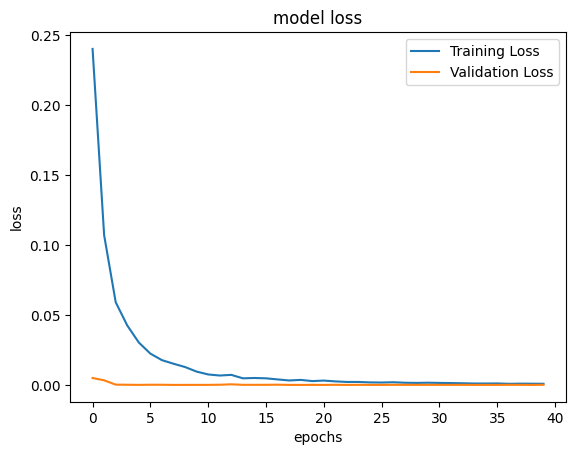

In [39]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

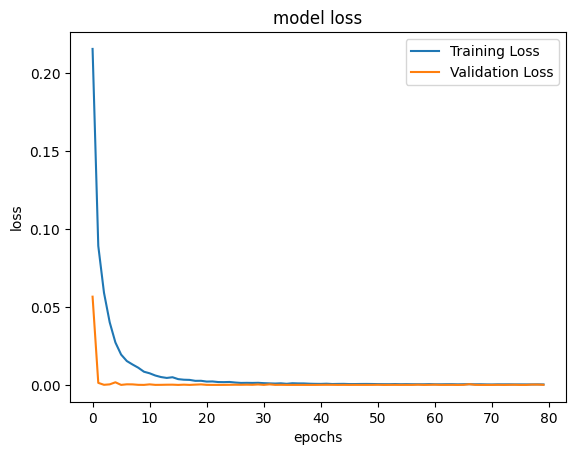

In [45]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [47]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{epoch_no}epochs')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_Original_80epochs/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_Original_80epochs/assets


In [31]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 30, 70)            5040      
                                                                 
 dropout_20 (Dropout)        (None, 30, 70)            0         
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 70)                9870      
                                                                 
 dropout_21 (Dropout)        (None, 70)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 71        
                                                                 
Total params: 14981 (58.52 KB)
Trainable params: 14981 (58.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [42]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


In [46]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


In [ ]:
plot_comparison(y_test,predicted_stock_price_raw)

#### AKAM - Filtered(SMA)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- SMA


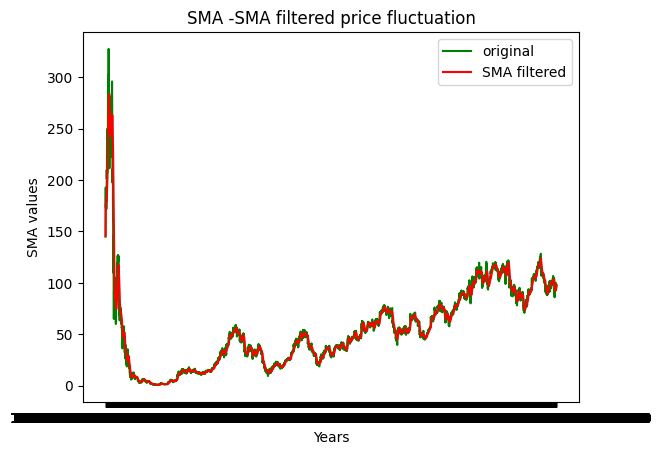

In [48]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
sma_win=20
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Train model with best values

{'win_size': 20,
 'epoch_no': 40,
 'split_size': 0.4,
 'units': 50,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'huber_loss',
 'activation_name': 'gelu'}

In [50]:
win_size=20 #study_cnn.best_trial.params['win_size']
epoch_no=80 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=50 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'adamax' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='huber_loss' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)
Epoch 1/80
119/119 [==============================] - 9s 49ms/step - loss: 0.1467 - val_loss: 0.0020
Epoch 2/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0687 - val_loss: 3.8275e-04
Epoch 3/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0391 - val_loss: 7.9810e-05
Epoch 4/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0279 - val_loss: 9.0479e-05
Epoch 5/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0207 - val_loss: 1.1607e-04
Epoch 6/80
119/119 [==============================] - 5s 45ms/step - loss: 0.0154 - val_loss: 2.3512e-05
Epoch 7/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0121 - val_loss: 3.8029e-04
Epoch 8/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0104 - val_loss: 6.4555e-04
Epoch 9/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0086

##### Evalute tuned model

In [51]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 11ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.01%
Mean Absolute Error (MAE): 1.48
Root Mean Squared Error (RMSE): 1.79
R2 Score: 0.97


##### Validation and training loss plot

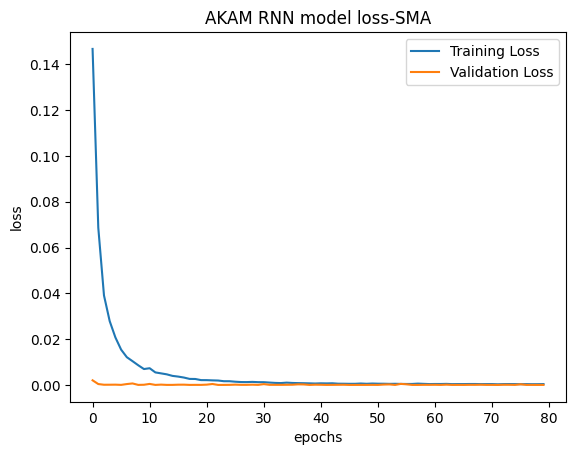

In [52]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [54]:
# Save the entire model as a `.keras` zip archive.
# best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_SMA/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_SMA/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [53]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(kalman)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- kalman


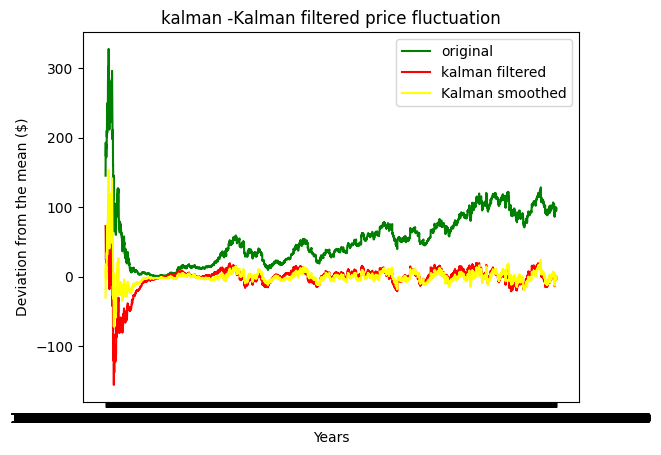

In [55]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="kalman" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="kalman"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [56]:
win_size=20 #study_cnn.best_trial.params['win_size']
epoch_no=80 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=50 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'adamax' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='huber_loss' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)
Epoch 1/80
119/119 [==============================] - 9s 50ms/step - loss: 0.3448 - val_loss: 0.0040
Epoch 2/80
119/119 [==============================] - 6s 47ms/step - loss: 0.2185 - val_loss: 0.0045
Epoch 3/80
119/119 [==============================] - 6s 47ms/step - loss: 0.1578 - val_loss: 0.0453
Epoch 4/80
119/119 [==============================] - 5s 46ms/step - loss: 0.1036 - val_loss: 0.0451
Epoch 5/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0732 - val_loss: 0.0509
Epoch 6/80
119/119 [==============================] - 6s 47ms/step - loss: 0.0526 - val_loss: 0.0435
Epoch 7/80
119/119 [==============================] - 6s 47ms/step - loss: 0.0395 - val_loss: 0.0317
Epoch 8/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0300 - val_loss: 0.0171
Epoch 9/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0212 - val_loss: 0.0192
Epoch 10

##### Evaluate trained model

In [57]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 10ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 2.53%
Mean Absolute Error (MAE): 4.18
Root Mean Squared Error (RMSE): 5.06
R2 Score: 0.70


##### Val and training loss plot

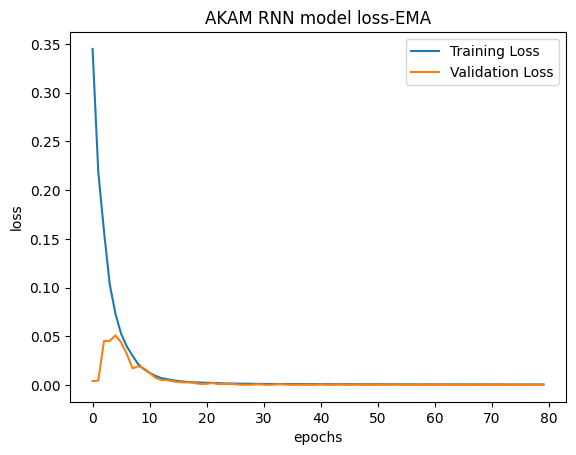

In [62]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [59]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_kalman/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_kalman/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [60]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(EMA)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- EMA


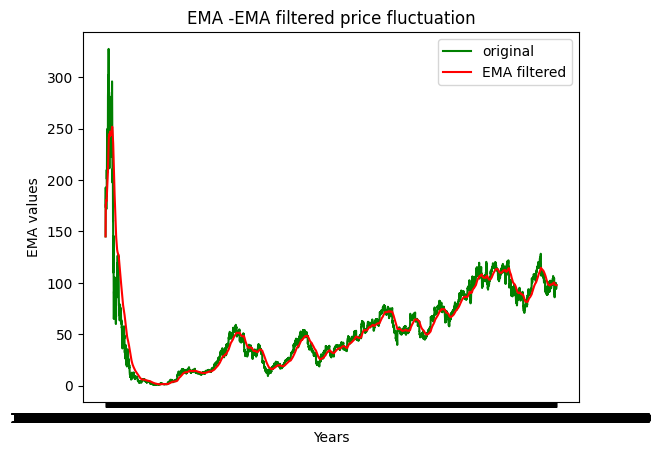

In [61]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
ema_win=100
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.
Filter Name- EMA


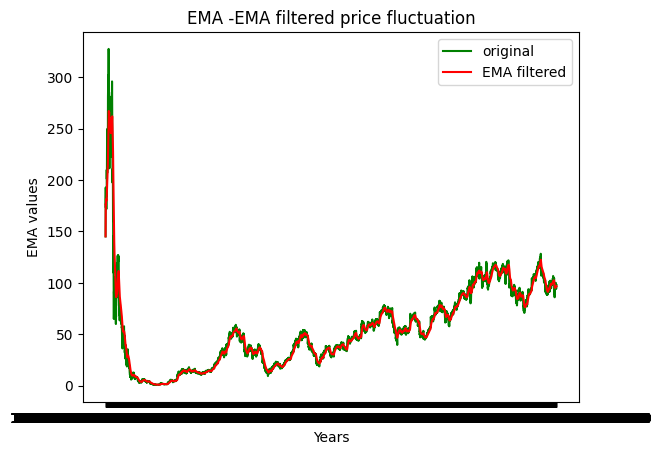

In [89]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
ema_win=30
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [63]:
win_size=20 #study_cnn.best_trial.params['win_size']
epoch_no=80 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=50 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'adamax' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='huber_loss' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)
Epoch 1/80
119/119 [==============================] - 8s 49ms/step - loss: 0.2326 - val_loss: 0.0208
Epoch 2/80
119/119 [==============================] - 5s 46ms/step - loss: 0.1167 - val_loss: 0.0012
Epoch 3/80
119/119 [==============================] - 6s 46ms/step - loss: 0.0672 - val_loss: 7.6055e-05
Epoch 4/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0487 - val_loss: 0.0010
Epoch 5/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0369 - val_loss: 0.0020
Epoch 6/80
119/119 [==============================] - 5s 46ms/step - loss: 0.0289 - val_loss: 4.5536e-06
Epoch 7/80
119/119 [==============================] - 6s 46ms/step - loss: 0.0218 - val_loss: 5.8927e-04
Epoch 8/80
119/119 [==============================] - 6s 46ms/step - loss: 0.0174 - val_loss: 0.0012
Epoch 9/80
119/119 [==============================] - 6s 47ms/step - loss: 0.0144 - val_loss: 6.7

In [90]:
win_size=20 #study_cnn.best_trial.params['win_size']
epoch_no=80 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=50 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'adamax' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='huber_loss' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)
(20, 1)


2025-01-01 10:44:11.590737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1026 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-01-01 10:44:11.677410: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 10:44:11.679194: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-01 10:44:11.679206: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-01 10:44:11.679248: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compi

Epoch 1/80


2025-01-01 10:44:14.292509: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 10:44:14.294384: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-01 10:44:14.463053: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 10:44:14.464100: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

119/119 [==============================] - 9s 47ms/step - loss: 0.2186 - val_loss: 0.0028
Epoch 2/80
119/119 [==============================] - 5s 43ms/step - loss: 0.0925 - val_loss: 0.0011
Epoch 3/80
119/119 [==============================] - 5s 43ms/step - loss: 0.0589 - val_loss: 0.0021
Epoch 4/80
119/119 [==============================] - 5s 43ms/step - loss: 0.0411 - val_loss: 6.4075e-04
Epoch 5/80
119/119 [==============================] - 5s 44ms/step - loss: 0.0304 - val_loss: 0.0013
Epoch 6/80
119/119 [==============================] - 5s 44ms/step - loss: 0.0232 - val_loss: 0.0017
Epoch 7/80
119/119 [==============================] - 5s 44ms/step - loss: 0.0173 - val_loss: 5.3930e-04
Epoch 8/80
119/119 [==============================] - 5s 43ms/step - loss: 0.0148 - val_loss: 6.6648e-04
Epoch 9/80
119/119 [==============================] - 5s 44ms/step - loss: 0.0117 - val_loss: 3.3683e-05
Epoch 10/80
119/119 [==============================] - 5s 44ms/step - loss: 0.0103 - v

##### Evaluate trained model

In [64]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 10ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 3.92
Root Mean Squared Error (RMSE): 4.03
R2 Score: 0.81


In [91]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 9ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 3.99
Root Mean Squared Error (RMSE): 4.11
R2 Score: 0.85


##### Val and training loss plot

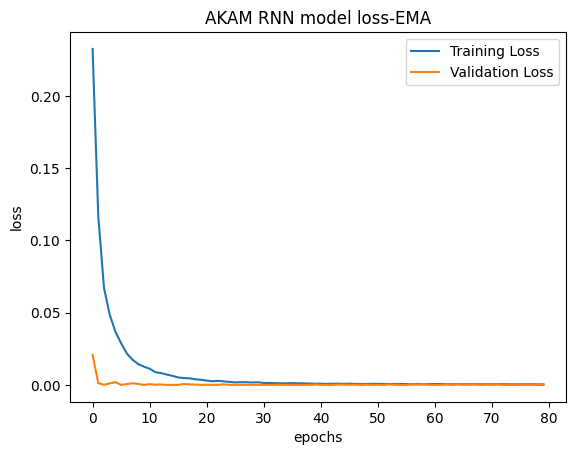

In [65]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

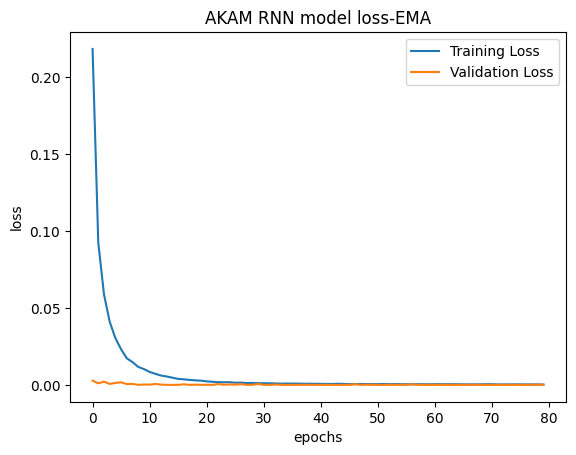

In [92]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [67]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{ema_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_EMA_100/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_EMA_100/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [66]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [93]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(MACD)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MACD" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MACD"
abc(ticker,n_trial,filter,f"{study_naam}",batch_size_no,attn)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_rnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [ ]:
study_rnn.best_trial.params

##### After hyperparameter tuning - Evaluate model with best values

In [ ]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

##### Evaluate trained model

In [ ]:
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### AKAM - Filtered(Fourier)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


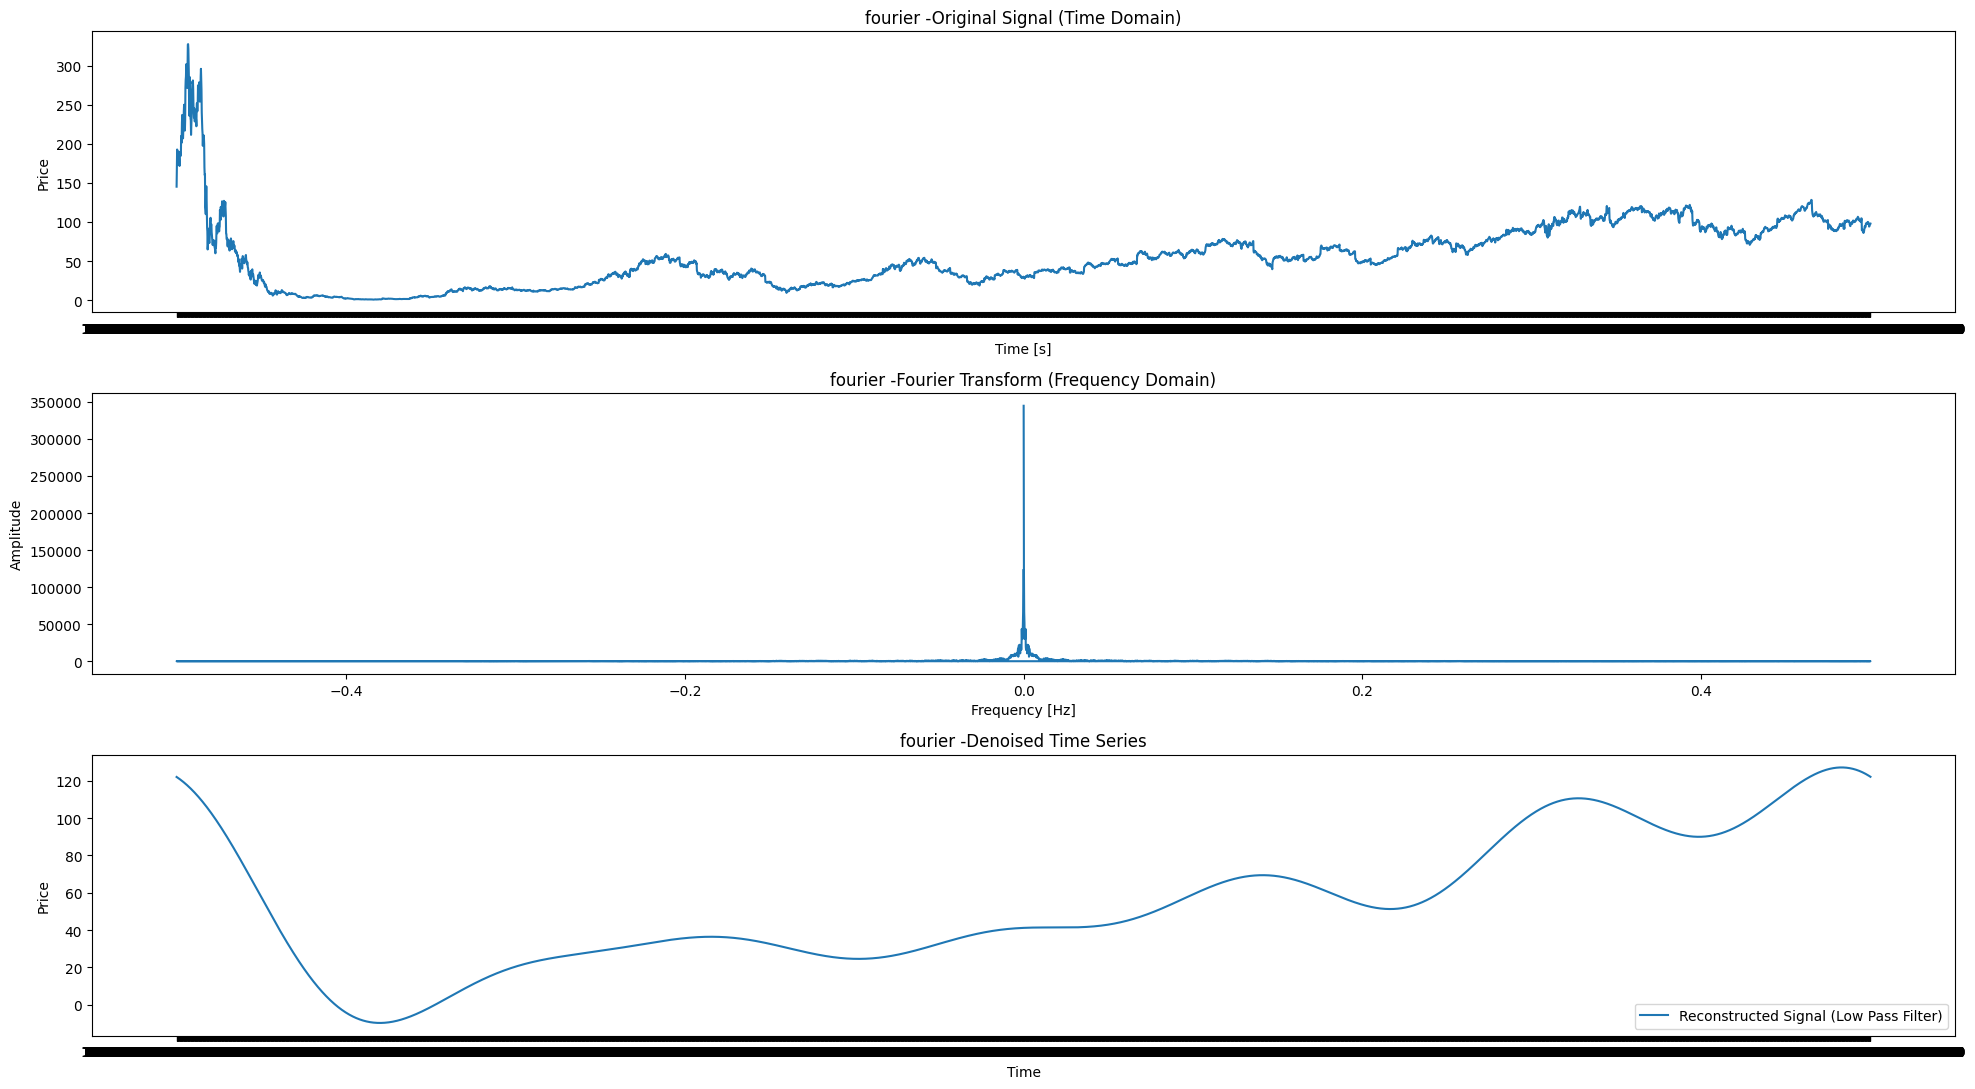

Filter Name- fourier


In [96]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.001 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


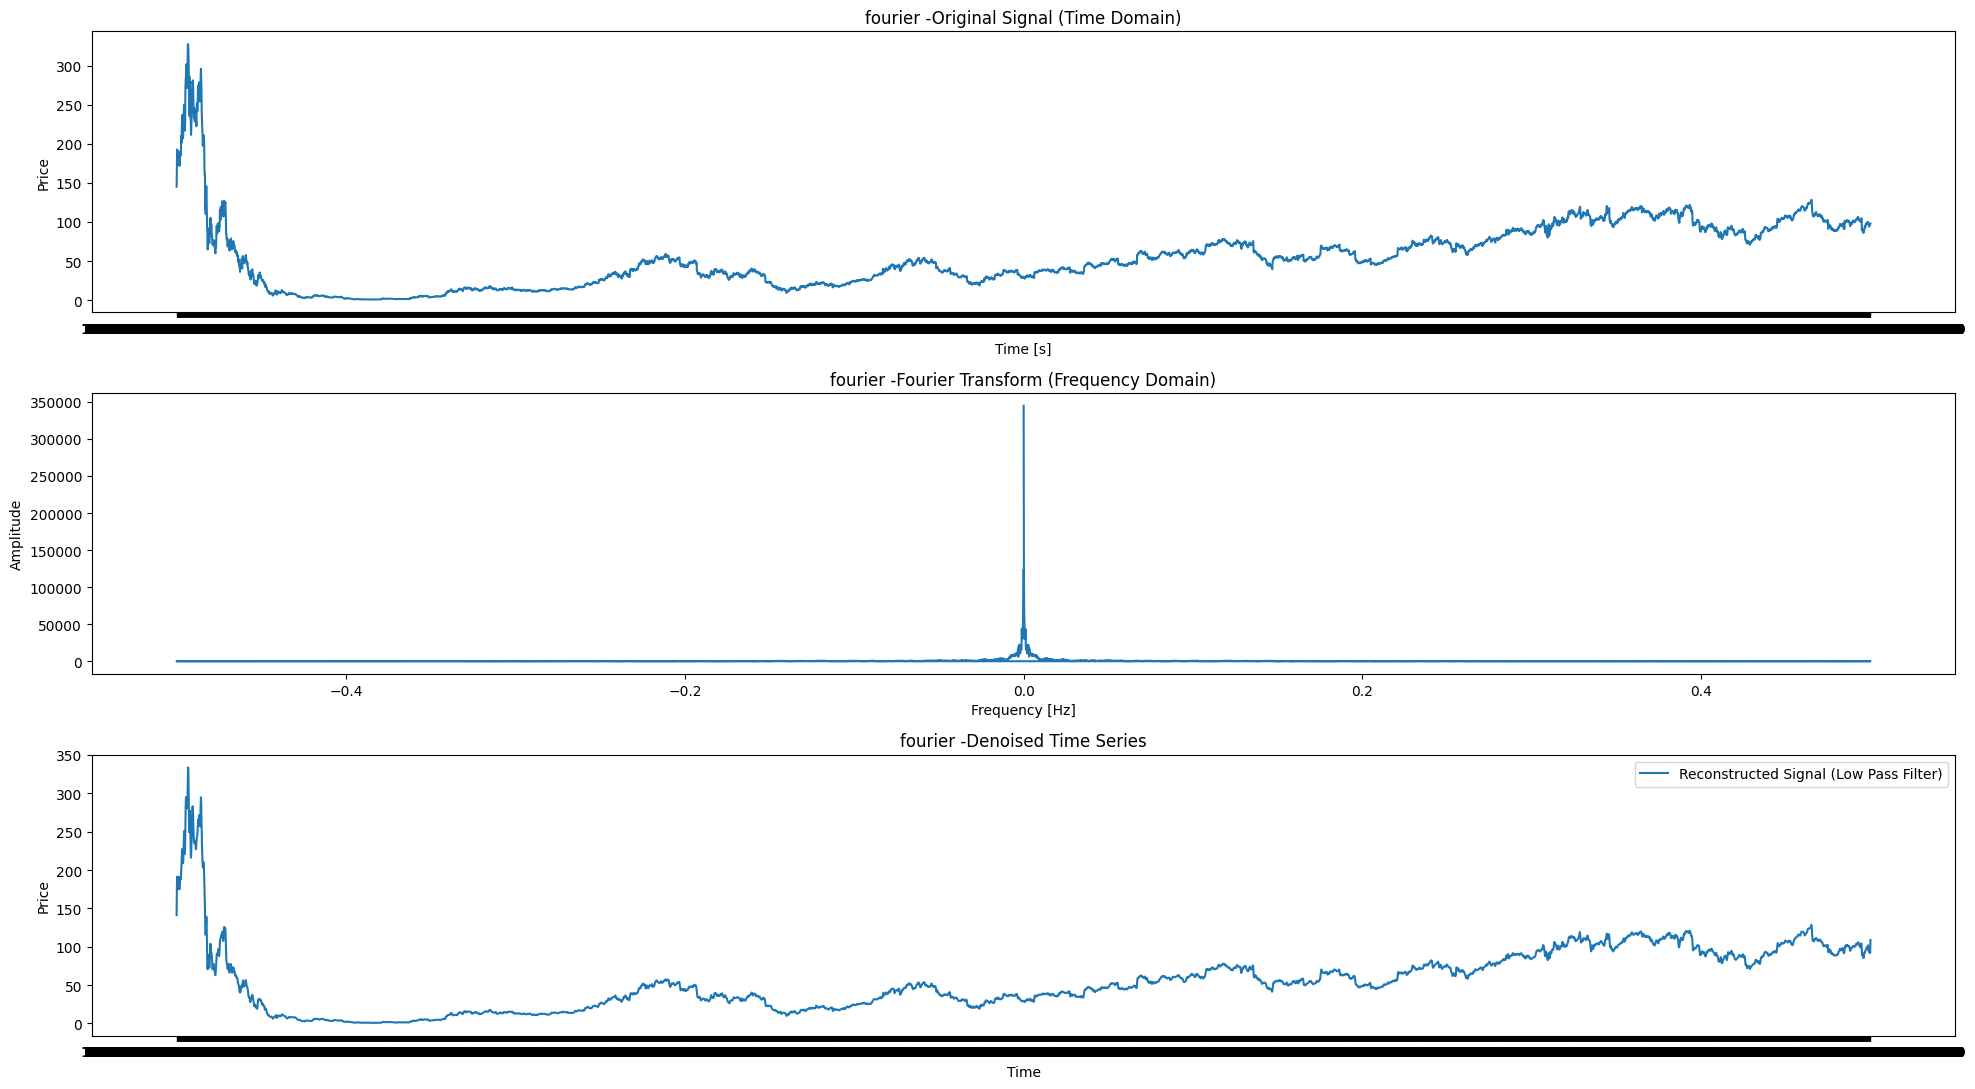

Filter Name- fourier


In [29]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.2 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'MMM_data.csv' does exist.
freq- [ 0.00000000e+00  6.30596544e-05  1.26119309e-04 ... -1.89178963e-04
 -1.26119309e-04 -6.30596544e-05]
amp- [481834.98220405 342477.60698646 202498.46453316 ... 151759.17583392
 202498.46453316 342477.60698646]


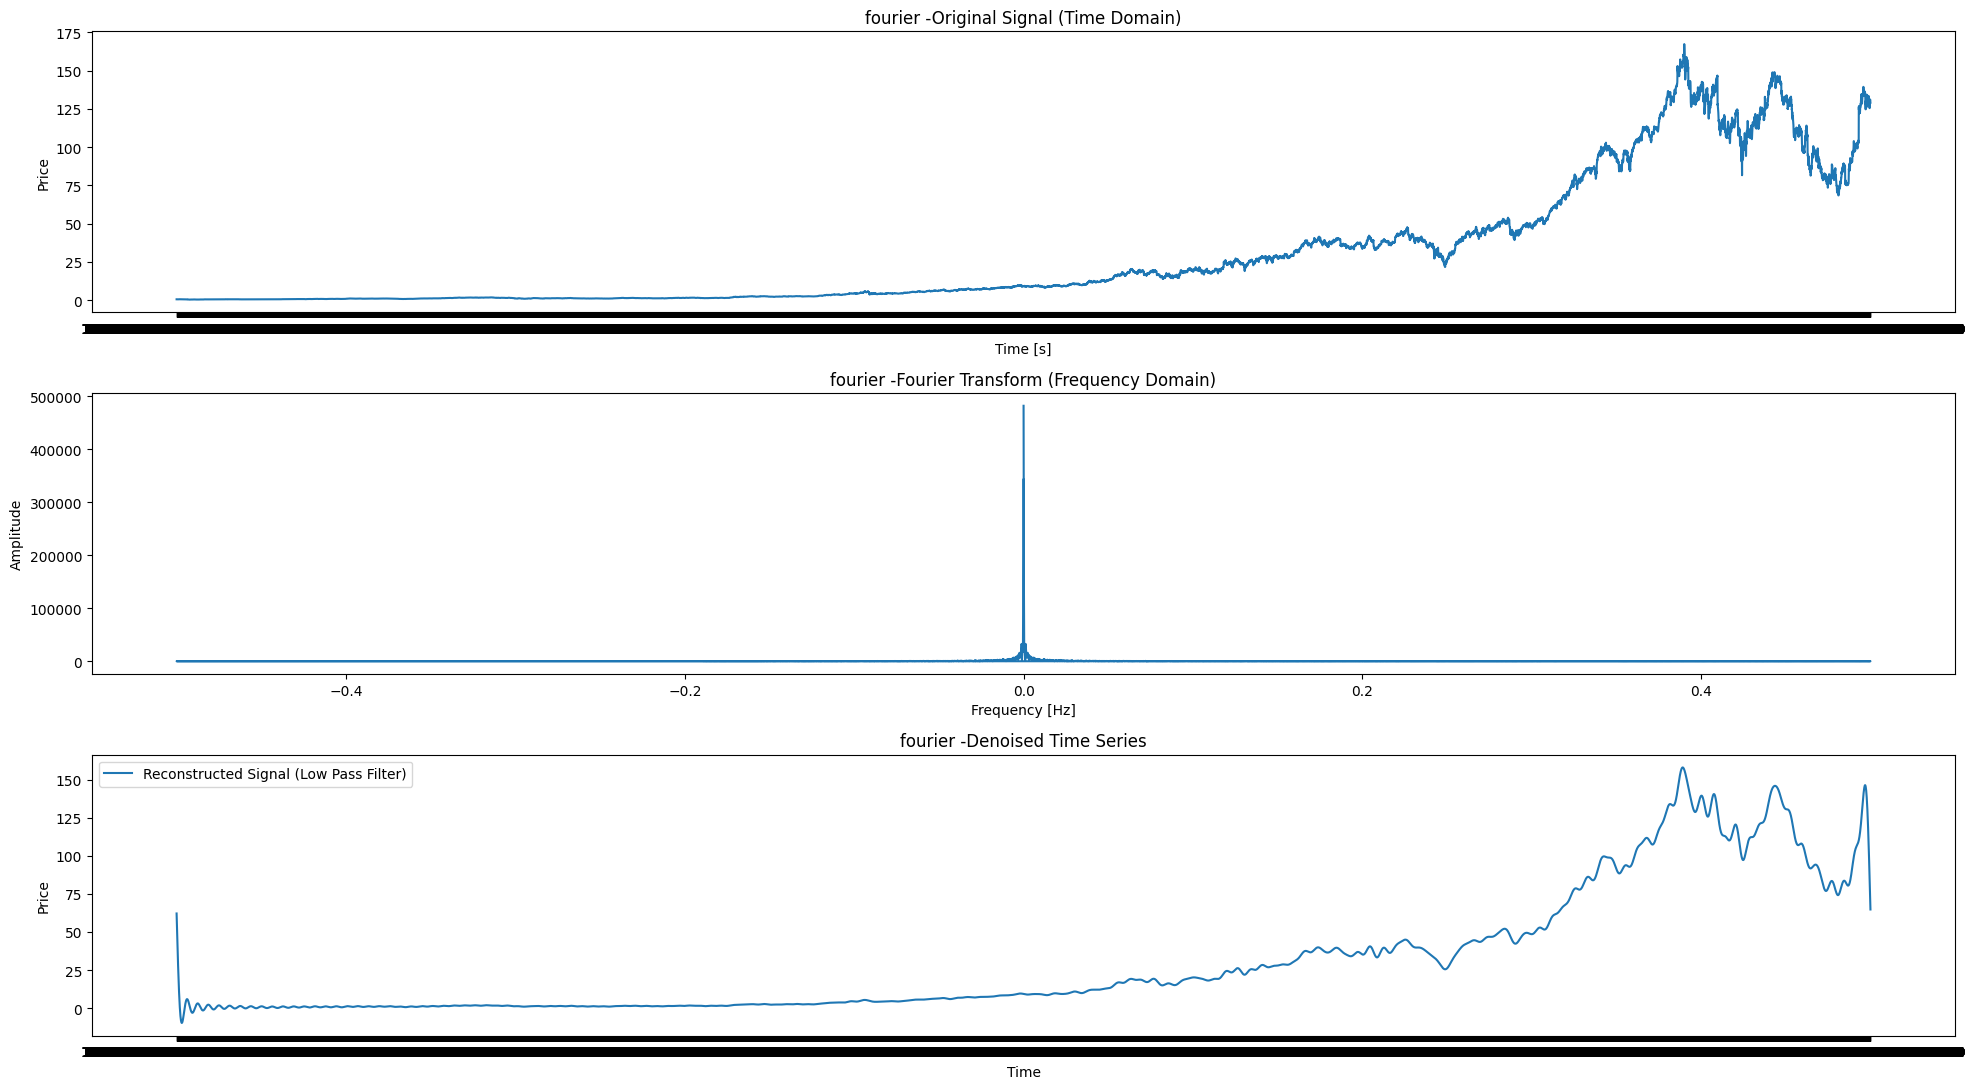

Filter Name- fourier


In [106]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.01 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Train model with best values

In [97]:
win_size=10 #study_cnn.best_trial.params['win_size']
epoch_no=100 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=30 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
(10, 1)
Epoch 1/100


2025-01-01 11:11:29.910659: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 11:11:29.912408: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-01 11:11:29.958066: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 11:11:29.960758: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-01 11:11:30.029817: E external/local_xla/xla/str

  7/119 [>.............................] - ETA: 3s - loss: 0.3186

2025-01-01 11:11:31.758154: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 8s 33ms/step - loss: 0.2007 - val_loss: 0.0034
Epoch 2/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0775 - val_loss: 0.0024
Epoch 3/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0395 - val_loss: 0.0019
Epoch 4/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0225 - val_loss: 8.5486e-04
Epoch 5/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0142 - val_loss: 0.0019
Epoch 6/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0098 - val_loss: 7.8016e-04
Epoch 7/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0071 - val_loss: 3.4428e-04
Epoch 8/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0056 - val_loss: 3.1920e-04
Epoch 9/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0052 - val_loss: 6.5157e-04
Epoch 10/100
119/119 [==============================] - 4s 30ms/step - los

In [31]:
win_size=10 #study_cnn.best_trial.params['win_size']
epoch_no=100 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=30 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


InternalError: cudaSetDevice() on GPU:0 failed. Status: out of memory

In [107]:
win_size=10 #study_cnn.best_trial.params['win_size']
epoch_no=100 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=30 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (9508, 10)
scaled X_train size (9508, 10, 1) (9508,)
(10, 1)
Epoch 1/100
298/298 [==============================] - 13s 31ms/step - loss: 0.0813 - val_loss: 0.0142
Epoch 2/100
298/298 [==============================] - 9s 30ms/step - loss: 0.0079 - val_loss: 0.0308
Epoch 3/100
298/298 [==============================] - 9s 29ms/step - loss: 0.0037 - val_loss: 0.0191
Epoch 4/100
298/298 [==============================] - 9s 30ms/step - loss: 0.0022 - val_loss: 0.0156
Epoch 5/100
298/298 [==============================] - 9s 29ms/step - loss: 0.0017 - val_loss: 0.0149
Epoch 6/100
298/298 [==============================] - 9s 30ms/step - loss: 0.0013 - val_loss: 0.0139
Epoch 7/100
298/298 [==============================] - 9s 29ms/step - loss: 0.0011 - val_loss: 0.0139
Epoch 8/100
298/298 [==============================] - 9s 29ms/step - loss: 9.6220e-04 - val_loss: 0.0138
Epoch 9/100
298/298 [==============================] - 9s 29ms/step - loss: 8.4111e-04 - val_los

##### Evaluate trained model

In [98]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 6ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.77
Root Mean Squared Error (RMSE): 5.44
R2 Score: 0.79


In [103]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

100/100 [==============================] - 1s 6ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.79%
Mean Absolute Error (MAE): 83.83
Root Mean Squared Error (RMSE): 87.96
R2 Score: -10.23


In [108]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

100/100 [==============================] - 1s 6ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.64%
Mean Absolute Error (MAE): 69.32
Root Mean Squared Error (RMSE): 73.60
R2 Score: -6.95


##### Val and training loss plot

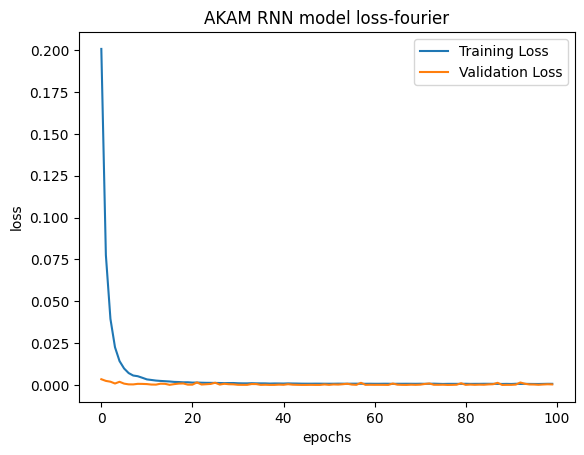

In [99]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

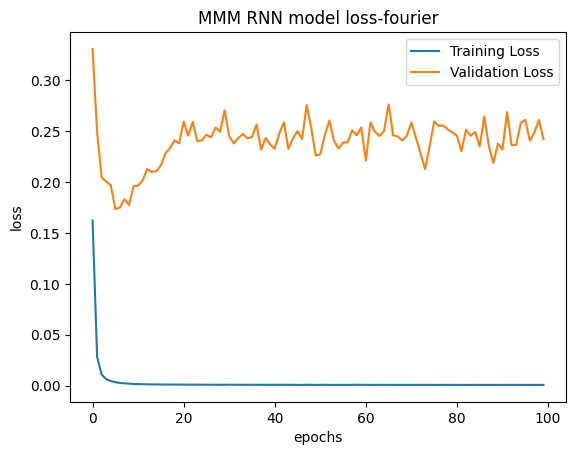

In [104]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

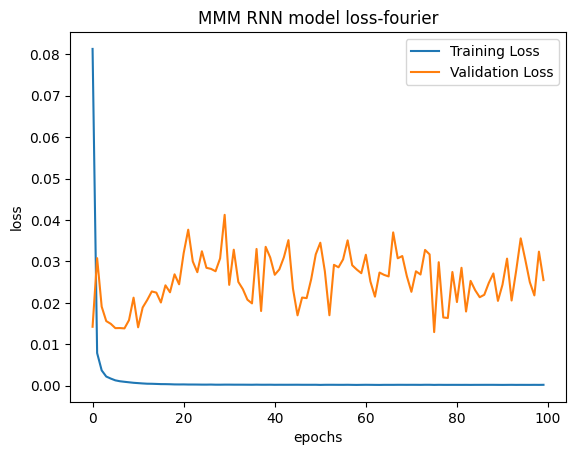

In [109]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{threshold}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [100]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [105]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [110]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(Wavelet)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
length of details- 6
Threshold enabled- False


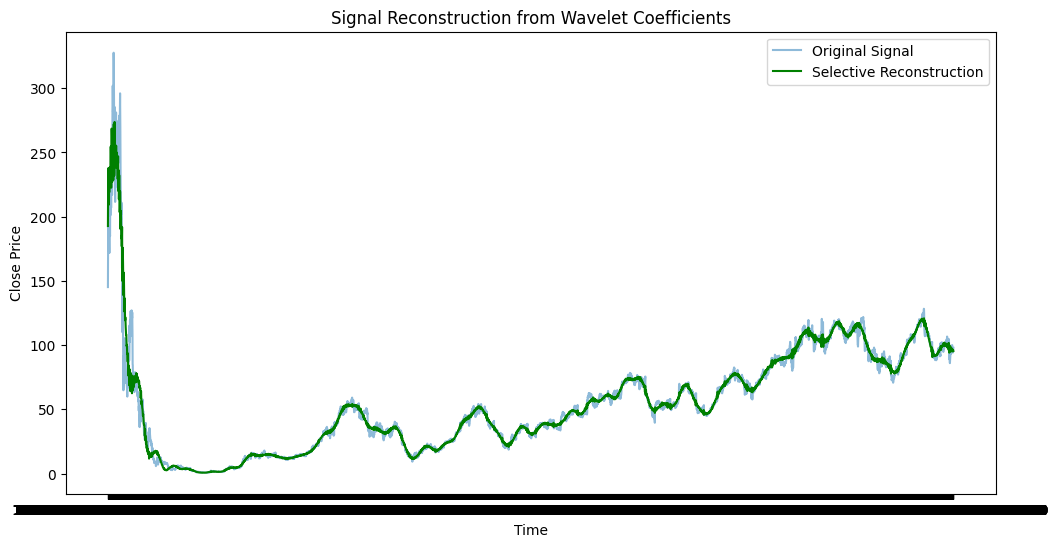

Filter Name- wavelet


In [29]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=4
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AKAM_data.csv' does exist.
length of details- 7
Threshold enabled- False


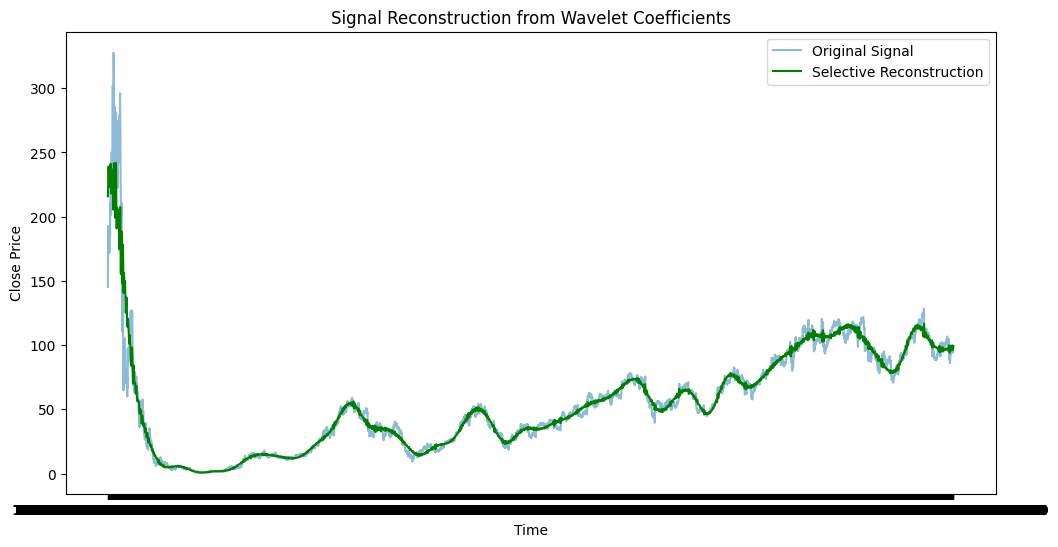

Filter Name- wavelet


In [38]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=4
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AKAM_data.csv' does exist.
length of details- 9
Threshold enabled- False


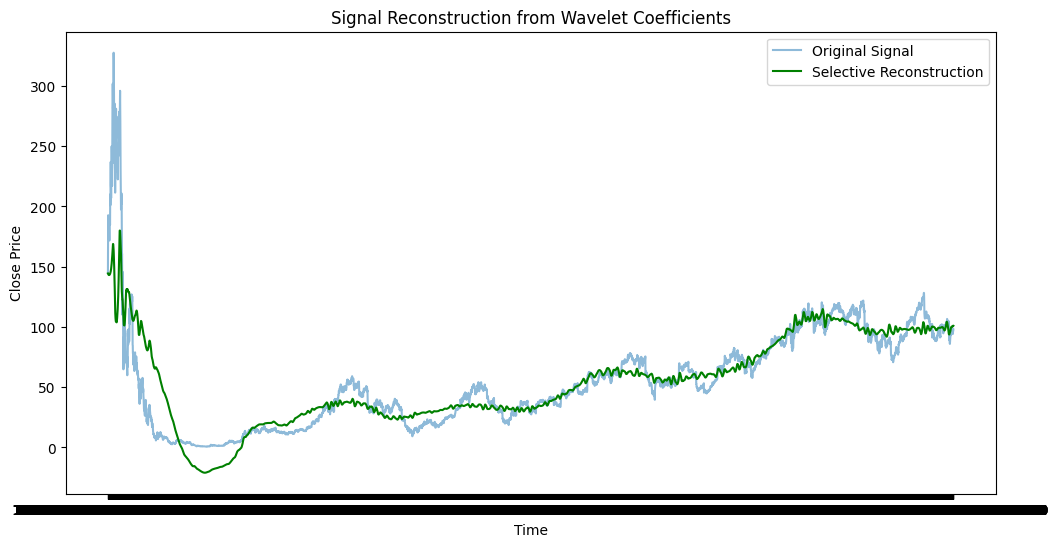

Filter Name- wavelet


In [44]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=4
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="db4"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

##### After hyperparameter tuning - Train model with best values

In [30]:
win_size=10 #study_cnn.best_trial.params['win_size']
epoch_no=100 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=30 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


2025-01-02 17:45:02.675113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-01-02 17:45:02.853932: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-02 17:45:02.856006: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-02 17:45:02.856019: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-02 17:45:02.856076: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to comp

(10, 1)
Epoch 1/100


2025-01-02 17:45:05.657950: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-02 17:45:05.659685: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-02 17:45:05.836602: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-02 17:45:05.837820: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

  4/119 [>.............................] - ETA: 2s - loss: 0.2421  

2025-01-02 17:45:07.539702: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-02 17:45:07.611051: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 8s 32ms/step - loss: 0.0872 - val_loss: 3.3250e-05
Epoch 2/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0200 - val_loss: 4.0068e-04
Epoch 3/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0103 - val_loss: 1.8914e-05
Epoch 4/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0083 - val_loss: 6.2295e-04
Epoch 5/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0051 - val_loss: 2.4590e-05
Epoch 6/100
119/119 [==============================] - 3s 28ms/step - loss: 0.0048 - val_loss: 3.1444e-05
Epoch 7/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0040 - val_loss: 5.6269e-04
Epoch 8/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0035 - val_loss: 2.6361e-04
Epoch 9/100
119/119 [==============================] - 3s 28ms/step - loss: 0.0030 - val_loss: 4.6993e-05
Epoch 10/100
119/119 [==============================] - 3s

In [39]:
win_size=10 #study_cnn.best_trial.params['win_size']
epoch_no=100 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=30 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
(10, 1)
Epoch 1/100
119/119 [==============================] - 7s 33ms/step - loss: 0.1553 - val_loss: 0.0016
Epoch 2/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0422 - val_loss: 0.0023
Epoch 3/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0203 - val_loss: 6.0586e-04
Epoch 4/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0119 - val_loss: 2.8244e-04
Epoch 5/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0096 - val_loss: 7.6399e-04
Epoch 6/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0078 - val_loss: 5.5621e-04
Epoch 7/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0059 - val_loss: 8.3035e-04
Epoch 8/100
119/119 [==============================] - 4s 29ms/step - loss: 0.0051 - val_loss: 9.2711e-04
Epoch 9/100
119/119 [==============================] - 4s 30ms/step - loss: 0

In [45]:
win_size=10 #study_cnn.best_trial.params['win_size']
epoch_no=100 #study_cnn.best_trial.params['epoch_no']
drop_out=0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units=30 #study_cnn.best_trial.params['units']
split_size=0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options = 'nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option='log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu' #study_cnn.best_trial.params['activation_name']

# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)
(10, 1)
Epoch 1/100
119/119 [==============================] - 8s 34ms/step - loss: 0.2067 - val_loss: 0.0018
Epoch 2/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0786 - val_loss: 0.0109
Epoch 3/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0382 - val_loss: 0.0020
Epoch 4/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0185 - val_loss: 0.0012
Epoch 5/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0119 - val_loss: 5.5873e-04
Epoch 6/100
119/119 [==============================] - 4s 31ms/step - loss: 0.0082 - val_loss: 1.4768e-04
Epoch 7/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0063 - val_loss: 8.7134e-04
Epoch 8/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0051 - val_loss: 1.4760e-04
Epoch 9/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0041 - 

##### Evaluate trained model

In [34]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 6ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.11
Root Mean Squared Error (RMSE): 3.33
R2 Score: 0.90


In [40]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 7ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 8.00
Root Mean Squared Error (RMSE): 8.09
R2 Score: 0.32


In [46]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 6ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.06%
Mean Absolute Error (MAE): 5.90
Root Mean Squared Error (RMSE): 6.02
R2 Score: -0.51


##### Val and training loss plot

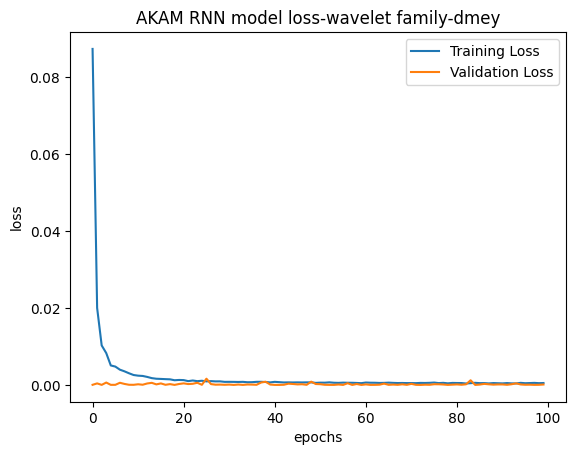

In [35]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

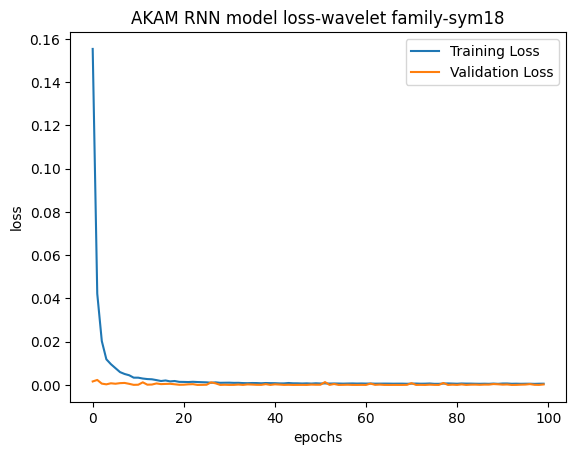

In [41]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

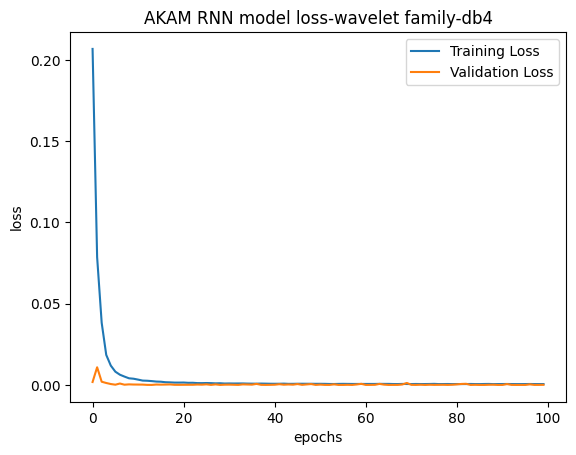

In [47]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [48]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{wavelet_name}({detail_index})')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_wavelet_db4(4)/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_wavelet_db4(4)/assets


In [32]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 30)            960       
                                                                 
 dropout (Dropout)           (None, 10, 30)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 30)            1830      
                                                                 
 dropout_1 (Dropout)         (None, 10, 30)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10, 30)            1830      
                                                                 
 dropout_2 (Dropout)         (None, 10, 30)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 30)                1

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [37]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [43]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [49]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(MSTL)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="mstl" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="mstl"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_rnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [ ]:
study_rnn.best_trial.params

##### After hyperparameter tuning - Train model with best values

In [ ]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

##### Evaluate trained model

In [51]:
X_test_unfilt.shape

(719, 40)

In [52]:
type(X_test_unfilt)

numpy.ndarray

In [ ]:
X_test_unfilt

In [ ]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_rnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### TSLA - Filtered(STL)

##### Start Tuning

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="STL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="STL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

[I 2024-12-02 13:44:39,630] A new study created in memory with name: STL
2024-12-02 13:44:39.751585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1237 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-12-02 13:44:40.012046: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:44:40.014308: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-02 13:44:40.014347: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-02 13:44:40.014431: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.

Epoch 1/5


2024-12-02 13:44:41.446326: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:44:41.447749: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-02 13:44:41.600319: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:44:41.603217: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

79/79 [==============================] - 6s 49ms/step - loss: 0.0047 - val_loss: 0.0088
Epoch 2/5
79/79 [==============================] - 4s 45ms/step - loss: 0.0015 - val_loss: 0.0155
Epoch 3/5
79/79 [==============================] - 4s 45ms/step - loss: 0.0013 - val_loss: 0.0252
Epoch 4/5
79/79 [==============================] - 4s 45ms/step - loss: 0.0012 - val_loss: 0.1273
Epoch 5/5
79/79 [==============================] - 4s 45ms/step - loss: 8.1449e-04 - val_loss: 0.0113


[I 2024-12-02 13:45:00,808] Trial 0 finished with value: 0.008774864487349987 and parameters: {'win_size': 50, 'epoch_no': 5, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4}. Best is trial 0 with value: 0.008774864487349987.


loss value [0.008774864487349987, 0.015489399433135986, 0.025227146223187447, 0.12730969488620758, 0.011294898577034473]
Epoch 1/20
79/79 [==============================] - 5s 42ms/step - loss: 0.0072 - val_loss: 0.0573
Epoch 2/20
79/79 [==============================] - 3s 40ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 3/20
79/79 [==============================] - 3s 39ms/step - loss: 8.9116e-04 - val_loss: 0.0015
Epoch 4/20
79/79 [==============================] - 3s 38ms/step - loss: 5.5106e-04 - val_loss: 0.0038
Epoch 5/20
79/79 [==============================] - 3s 39ms/step - loss: 7.0537e-04 - val_loss: 0.0297
Epoch 6/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 7/20
79/79 [==============================] - 3s 40ms/step - loss: 5.8315e-04 - val_loss: 0.0707
Epoch 8/20
79/79 [==============================] - 3s 40ms/step - loss: 4.4018e-04 - val_loss: 0.0016
Epoch 9/20
79/79 [==============================] - 3s 39ms/step - 

[I 2024-12-02 13:46:04,743] Trial 1 finished with value: 0.0006172003340907395 and parameters: {'win_size': 40, 'epoch_no': 20, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4}. Best is trial 1 with value: 0.0006172003340907395.


loss value [0.05730018392205238, 0.0020064671989530325, 0.0014525745064020157, 0.00379219651222229, 0.02966640703380108, 0.0052816253155469894, 0.07066012918949127, 0.001597434631548822, 0.0046530552208423615, 0.007905146107077599, 0.0006172003340907395, 0.004171191714704037, 0.000988028128631413, 0.0006287442520260811, 0.002640767488628626, 0.001409321092069149, 0.0030129598453640938, 0.0015364211285486817, 0.011246619746088982, 0.001485115964896977]
Best parameters: for STL filter {'win_size': 40, 'epoch_no': 20, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4}
Best value: for STL filter 0.0006172003340907395
    win_size: 40
    epoch_no: 20
    split_size: 0.30000000000000004
    units: 50
    drop_out: 0.4


({'win_size': 40,
  'epoch_no': 20,
  'split_size': 0.30000000000000004,
  'units': 50,
  'drop_out': 0.4},
 0.0006172003340907395)

##### Best parameter values

In [34]:
study_rnn.best_trial.params

{'win_size': 40,
 'epoch_no': 20,
 'split_size': 0.30000000000000004,
 'units': 50,
 'drop_out': 0.4}

##### After hyperparameter tuning - Train model with best values

In [35]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0

best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/20
79/79 [==============================] - 5s 41ms/step - loss: 0.0099 - val_loss: 0.0155
Epoch 2/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0018 - val_loss: 0.0258
Epoch 3/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0010 - val_loss: 0.0143
Epoch 4/20
79/79 [==============================] - 3s 39ms/step - loss: 8.0450e-04 - val_loss: 0.0141
Epoch 5/20
79/79 [==============================] - 3s 38ms/step - loss: 6.7514e-04 - val_loss: 0.0039
Epoch 6/20
79/79 [==============================] - 3s 40ms/step - loss: 5.1371e-04 - val_loss: 0.0095
Epoch 7/20
79/79 [==============================] - 3s 39ms/step - loss: 4.7500e-04 - val_loss: 0.0052
Epoch 8/20
79/79 [==============================] - 3s 39ms/step - loss: 3.3246e-04 - val_loss: 0.0072
Epoch 9/20
79/79 [==============================] - 3s 39ms/step - loss: 3.9058e-04 - val_loss: 0.0081
Epoch 10/20
79/79 [==============================] - 3s 40ms/step - loss: 3.9896e-04 

##### Evaluate trained model

In [36]:
X_test_unfilt.shape

(1078, 40)

In [40]:
type(X_test_unfilt)

numpy.ndarray

In [41]:
X_test_unfilt

array([[0.1772717 , 0.16990007, 0.17442608, ..., 0.29414616, 0.32745267,
        0.33671899],
       [0.16990007, 0.17442608, 0.16970016, ..., 0.32745267, 0.33671899,
        0.33517731],
       [0.17442608, 0.16970016, 0.17863509, ..., 0.33671899, 0.33517731,
        0.35738406],
       ...,
       [0.69390169, 0.66958778, 0.64700282, ..., 0.91440227, 0.94930625,
        0.91156559],
       [0.66958778, 0.64700282, 0.67245142, ..., 0.94930625, 0.91156559,
        0.91059308],
       [0.64700282, 0.67245142, 0.64746208, ..., 0.91156559, 0.91059308,
        0.89616681]])

In [38]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_rnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

34/34 [==============================] - 0s 9ms/step
**********************STL filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 19.01
Root Mean Squared Error (RMSE): 23.06
R2 Score: 0.84


##### Val and training loss plot

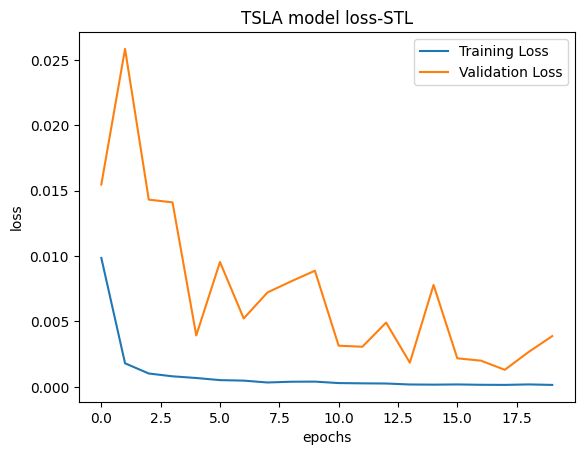

In [39]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [42]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 40, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 40, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7701 (30.08 KB)
Trainable params: 7701 (30.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

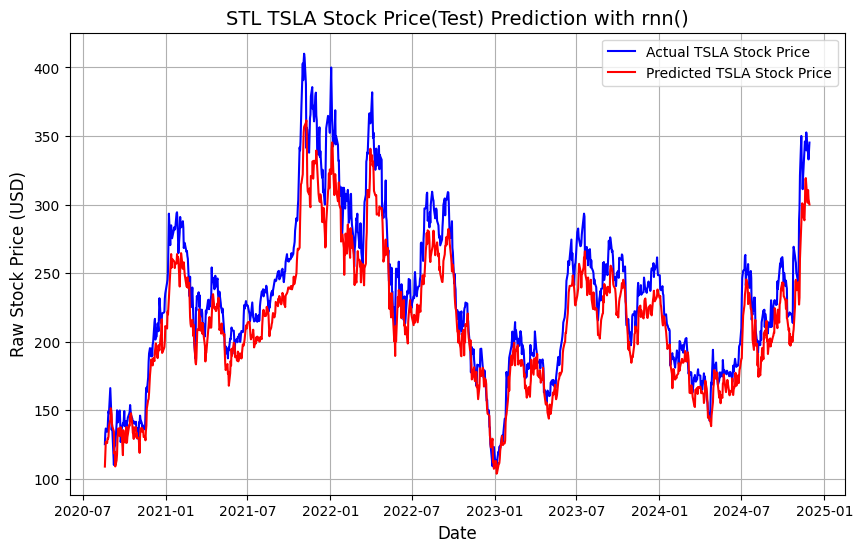

In [43]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

In [ ]:
rt_fft = tf.signal.fft(tesla_data['Close'])
fft = tf.signal.rfft(tesla_data[['Close']])
np.fft.fft(tesla_data['Close'])
recovered = tf.signal.ifft(rt_fft)
#plot tesla_data['Close] and recovered with x axis as tesla_data.index
plt.figure(figsize=(16,8))
plt.plot(tesla_data.index,tesla_data['Close'], label='Org Price', color='blue')
plt.plot(tesla_data.index,recovered, label='Rec Price', color='green')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [72]:
len(tesla_data['Close'])

5534

In [ ]:
# import scipy.fft as fft
# # Generate a time-domain signal
# t = np.linspace(0, 1, 1000)
# x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)

# # Calculate the Fourier Transform
# X = fft.fft(tesla_data['Close'].values)
# freqs = fft.fftfreq(tesla_data['Close'].size,d=1)  # Calculate the frequencies

# from scipy import signal
# sos = signal.butter(2, 0.001, 'low', analog=False,output='sos')
# filtered = signal.sosfilt(sos, tesla_data[['Close']])
# # w, h = signal.freqs(b, a)

# # Plot the frequency-domain representation of the signal
# import matplotlib.pyplot as plt
# plt.plot(freqs, np.abs(X))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim([0, 50])  # Display frequencies from 0 to 50 Hz for clarity
# plt.show()

# #Plot the filtered data
# plt.figure(figsize=(10,6))
# plt.plot(tesla_data.index,filtered,label="filtered")
# plt.plot(tesla_data.index,tesla_data[['Close']],label="Actual")
# plt.title('Filtered Data')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()


#### AKAM - Proposed Filter(hybrid) - fourier_wavelet

In [29]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="hybrid" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="hybrid"
tuning=False
stock_file_name="AKAM_autoencoder_data.csv"
detail_index=8
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

##### After hyperparameter tuning - Evaluate model with best values

In [31]:
win_size= 10 #study_cnn.best_trial.params['win_size']
epoch_no= 100 #study_cnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units= 30 #study_cnn.best_trial.params['units']
split_size= 0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu' #study_cnn.best_trial.params['activation_name']
filter_size= 64 #study_cnn.best_trial.params['filter_size']
kernel_size= 3 #study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3795, 10)
scaled X_train size (3795, 10, 1) (3795,)
(10, 1)


2025-01-08 11:02:57.256132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1193 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-01-08 11:02:57.521671: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:02:57.524853: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-08 11:02:57.524878: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-08 11:02:57.524928: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compi

Epoch 1/100


2025-01-08 11:03:00.394724: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:03:00.398009: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-08 11:03:00.568134: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:03:00.568643: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

  5/119 [>.............................] - ETA: 3s - loss: 0.0066 

2025-01-08 11:03:02.441831: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 8s 31ms/step - loss: 0.0097 - val_loss: 1.2555e-06
Epoch 2/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0078 - val_loss: 8.1705e-06
Epoch 3/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0071 - val_loss: 5.0346e-07
Epoch 4/100
119/119 [==============================] - 3s 28ms/step - loss: 0.0063 - val_loss: 5.5666e-06
Epoch 5/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0042 - val_loss: 3.3235e-06
Epoch 6/100
119/119 [==============================] - 3s 28ms/step - loss: 0.0039 - val_loss: 1.8395e-07
Epoch 7/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0033 - val_loss: 2.1021e-06
Epoch 8/100
119/119 [==============================] - 3s 29ms/step - loss: 0.0036 - val_loss: 1.8275e-05
Epoch 9/100
119/119 [==============================] - 3s 28ms/step - loss: 0.0029 - val_loss: 1.1483e-04
Epoch 10/100
119/119 [==============================] - 3s

##### Evaluate Trained Model

In [32]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 6ms/step
**********************hybrid filter***************************
Mean Absolute Percentage Error (MAPE): 0.09%
Mean Absolute Error (MAE): 0.16
Root Mean Squared Error (RMSE): 0.28
R2 Score: 0.90


##### Val and training plot loss

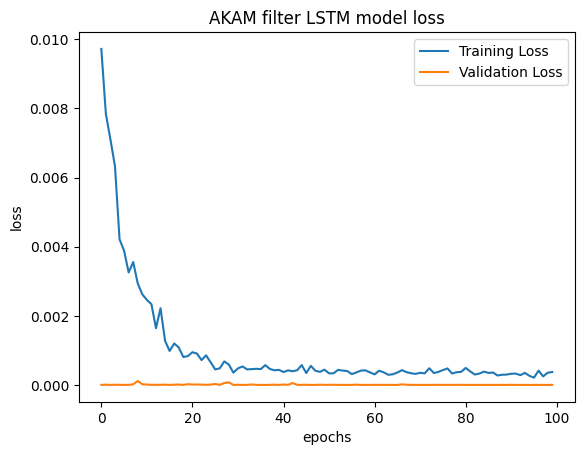

In [37]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} filter LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save Model

In [36]:
# Save the entire model as a `.keras` zip archive.
ticker="AKAM"
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_hybrid/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AKAM_model_hybrid/assets


##### Plot

In [38]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['org_akam']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************
